In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC1 = Path(HERE).resolve().parents[1]/'input'

In [3]:
df = pd.read_pickle(HDAC1/"HDAC1_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1
0,CHEMBL4176702,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[9413970, 7836485, 4703614, 8711586, 1857203, ...",6.50
1,CHEMBL272401,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","[6242194, 3827191, 2475943, 5652600, 2748816, ...",7.26
2,CHEMBL118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[5726680, 25018265, 38173396, 23403255, 169510...",5.93
3,CHEMBL3655939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[8343543, 2478511, 6486141, 299249, 11932100, ...",6.28
4,CHEMBL3621537,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 15365489, 24097203, 9391761, 6651314...",5.88


In [4]:
df_labeled = pd.read_csv(HDAC1/"HDAC1_dataset.csv", )
df_labeled

,molecule_chembl_id,smiles,type,Standard_Value_HDAC1,pChEMBL_HDAC1,label
0,CHEMBL327146,O=C(CCCCCC(C(=O)Nc1ccc2ncccc2c1)C(=O)Nc1ccc2nc...,IC50,1.00,9.00,Single points
1,CHEMBL116620,O=C(/C=C/c1cccc(C(C(=O)Nc2ccccc2)C(=O)Nc2ccccc...,IC50,1.00,9.00,Single points
2,CHEMBL2093007,C/C=C1\NC(=O)[C@@H](CSC)NC(=O)[C@@H](C(C)C)CC(...,IC50,6300.00,5.20,Single points
3,CHEMBL316457,CC(C)c1cc(C(C)C)c(S(=O)(=O)Nc2ccc(/C=C/C(=O)NO...,IC50,600.00,6.22,Single points
4,CHEMBL269692,O=C(NCc1ccc(C(=O)NO)cc1)OCc1cccnc1,IC50,3000.00,5.52,Single points
...,...,...,...,...,...,...
4487,CHEMBL4649511,O=C(CCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,3.30,8.48,Dual-binder
4488,CHEMBL4637976,O=C(CCCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,130.00,6.89,Single points
4489,CHEMBL4638227,CC(=O)Nc1ccc2c(c1)CN(C(=O)[C@H](N)Cc1ccc(Cl)cc...,IC50,8800.00,5.06,Single points
4490,CHEMBL4444219,CCCNNC(=O)/C=C/c1ccc(CNCCc2c(C)[nH]c3ccccc23)cc1,IC50,4.85,8.43,Single points


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')
df.tail()

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1,label
4487,CHEMBL2047606,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[15114361, 3821889, 7998790, 4833708, 16951091...",5.44,Single points
4488,CHEMBL217781,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3492127, 2201708, 2475943, 7125875, 5802687, ...",7.48,Single points
4489,CHEMBL2105763,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4277439, 2478511, 1683617, 1179055, 492964, 2...",9.92,HDAC1-selective
4490,CHEMBL3415969,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1821977, 756812, 526260, 718486, 1799526, 521...",5.75,Semi-selective
4491,CHEMBL467066,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8781729, 10511, 1052992, 2183376, 2852937, 37...",7.55,Single points


In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,pChEMBL_HDAC1,label,Class
0,CHEMBL4176702,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[9413970, 7836485, 4703614, 8711586, 1857203, ...",6.50,Single points,0.0
1,CHEMBL272401,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, ...","[6242194, 3827191, 2475943, 5652600, 2748816, ...",7.26,Dual-binder,3.0
2,CHEMBL118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[5726680, 25018265, 38173396, 23403255, 169510...",5.93,Non-binder,4.0
3,CHEMBL3655939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[8343543, 2478511, 6486141, 299249, 11932100, ...",6.28,Semi-selective,5.0


In [7]:
# Add column for activity
df["activity"] = np.zeros(len(df))

# Mark every molecule as active if pchembl value is >=6.6 0 otherwise
df.loc[df[df.pChEMBL_HDAC1 >= 6.6].index, "activity"] = 1.0

#By using Morgan fingerprints with radius of 3 and 1024 bits
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["pChEMBL_HDAC1"].values
Y_cat =  df["activity"].values
Y_class = df['Class'].values
indices =  np.array(df.index)


In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['pChEMBL_HDAC1'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['pChEMBL_HDAC1'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['activity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=16,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6) , 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.678596     0.016382
1                    TP       200.400000     7.545418
2                    TN       170.700000     7.832269
3                    FP        42.400000     7.074210
4                    FN        35.700000     3.802046
5              Accuracy         0.826134     0.018331
6             Precision         0.825612     0.026919
7           Sensitivity         0.848774     0.015849
8           Specificity         0.801250     0.030982
9              F1 score         0.836830     0.017572
10  F1 score (weighted)         0.825949     0.018476
11     F1 score (macro)         0.825230     0.018496
12    Balanced Accuracy         0.825011     0.018713
13                  MCC         0.651279     0.036591
14                  NPV         0.826920     0.018560
15              ROC_AUC         0.825011     0.018713
CPU times: user 3min 31s, sys: 307 ms, total: 3min 31s
Wall time: 16.7 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=16, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 09:23:32,911] A new study created in memory with name: RFRegressor
[I 2023-12-06 09:24:14,468] Trial 0 finished with value: 0.659267076967515 and parameters: {'n_estimators': 357}. Best is trial 0 with value: 0.659267076967515.
[I 2023-12-06 09:25:14,525] Trial 1 finished with value: 0.6597452991802513 and parameters: {'n_estimators': 528}. Best is trial 1 with value: 0.6597452991802513.
[I 2023-12-06 09:26:23,037] Trial 2 finished with value: 0.6600084438778697 and parameters: {'n_estimators': 607}. Best is trial 2 with value: 0.6600084438778697.
[I 2023-12-06 09:28:14,469] Trial 3 finished with value: 0.660259062615891 and parameters: {'n_estimators': 984}. Best is trial 3 with value: 0.660259062615891.
[I 2023-12-06 09:30:05,087] Trial 4 finished with value: 0.6603616349543182 and parameters: {'n_estimators': 965}. Best is trial 4 with value: 0.6603616349543182.
[I 2023-12-06 09:31:13,017] Trial 5 finished with value: 0.6599258509045776 and parameters: {'n_estimators':

	Number of trials: 50.0
	Best value (r2_score): 0.6604
	Best params:
		n_estimators: 901


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_0_cat = np.where((y_pred_rf_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.668049
1                    TP  410.000000
2                    TN  341.000000
3                    FP   89.000000
4                    FN   59.000000
5              Accuracy    0.835373
6             Precision    0.821643
7           Sensitivity    0.874200
8           Specificity    0.793000
9              F1 score    0.847107
10  F1 score (weighted)    0.834948
11     F1 score (macro)    0.834397
12    Balanced Accuracy    0.833612
13                  MCC    0.670675
14                  NPV    0.852500
15              ROC_AUC    0.833612


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 10:37:54,246] Trial 50 finished with value: 0.6524884277401968 and parameters: {'n_estimators': 782}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10:39:36,757] Trial 51 finished with value: 0.6525701448755248 and parameters: {'n_estimators': 895}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10:41:26,207] Trial 52 finished with value: 0.6526766529953709 and parameters: {'n_estimators': 958}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10:43:10,092] Trial 53 finished with value: 0.6525031345152434 and parameters: {'n_estimators': 909}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10:44:30,070] Trial 54 finished with value: 0.6521304014688827 and parameters: {'n_estimators': 715}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10:46:06,538] Trial 55 finished with value: 0.6524720739127592 and parameters: {'n_estimators': 849}. Best is trial 48 with value: 0.660424465293637.
[I 2023-12-06 10

	Number of trials: 100.0
	Best value (r2_score): 0.6604
	Best params:
		n_estimators: 901


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_1_cat = np.where((y_pred_rf_1 >= 6.6), 1, 0)

#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.668049    0.674609
1                    TP  410.000000  406.000000
2                    TN  341.000000  345.000000
3                    FP   89.000000   79.000000
4                    FN   59.000000   69.000000
5              Accuracy    0.835373    0.835373
6             Precision    0.821643    0.837113
7           Sensitivity    0.874200    0.854737
8           Specificity    0.793000    0.813700
9              F1 score    0.847107    0.845833
10  F1 score (weighted)    0.834948    0.835248
11     F1 score (macro)    0.834397    0.834611
12    Balanced Accuracy    0.833612    0.834208
13                  MCC    0.670675    0.669431
14                  NPV    0.852500    0.833300
15              ROC_AUC    0.833612    0.834208


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 11:59:54,265] Trial 100 finished with value: 0.6636536278418805 and parameters: {'n_estimators': 887}. Best is trial 100 with value: 0.6636536278418805.
[I 2023-12-06 12:01:36,533] Trial 101 finished with value: 0.6636399967906441 and parameters: {'n_estimators': 893}. Best is trial 100 with value: 0.6636536278418805.
[I 2023-12-06 12:03:15,134] Trial 102 finished with value: 0.6636754628289712 and parameters: {'n_estimators': 888}. Best is trial 102 with value: 0.6636754628289712.
[I 2023-12-06 12:04:56,000] Trial 103 finished with value: 0.6636145897103678 and parameters: {'n_estimators': 883}. Best is trial 102 with value: 0.6636754628289712.
[I 2023-12-06 12:06:37,290] Trial 104 finished with value: 0.6636196450605425 and parameters: {'n_estimators': 884}. Best is trial 102 with value: 0.6636754628289712.
[I 2023-12-06 12:08:11,666] Trial 105 finished with value: 0.6636299937667597 and parameters: {'n_estimators': 807}. Best is trial 102 with value: 0.6636754628289712

	Number of trials: 150.0
	Best value (r2_score): 0.6638
	Best params:
		n_estimators: 751


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_2_cat = np.where((y_pred_rf_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.668049    0.674609    0.679188
1                    TP  410.000000  406.000000  411.000000
2                    TN  341.000000  345.000000  342.000000
3                    FP   89.000000   79.000000   86.000000
4                    FN   59.000000   69.000000   60.000000
5              Accuracy    0.835373    0.835373    0.837597
6             Precision    0.821643    0.837113    0.826962
7           Sensitivity    0.874200    0.854737    0.872611
8           Specificity    0.793000    0.813700    0.799100
9              F1 score    0.847107    0.845833    0.849174
10  F1 score (weighted)    0.834948    0.835248    0.837235
11     F1 score (macro)    0.834397    0.834611    0.836635
12    Balanced Accuracy    0.833612    0.834208    0.835838
13                  MCC    0.670675    0.669431    0.674686
14                  NPV    0.852500    0.833300    0.850700
15              ROC_AUC    0.833612    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 13:05:28,931] Trial 150 finished with value: 0.6504685897970758 and parameters: {'n_estimators': 665}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 13:06:34,995] Trial 151 finished with value: 0.6507481925203087 and parameters: {'n_estimators': 559}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 13:07:42,991] Trial 152 finished with value: 0.6507255754296157 and parameters: {'n_estimators': 578}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 13:08:57,789] Trial 153 finished with value: 0.6503004248160842 and parameters: {'n_estimators': 636}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 13:10:00,090] Trial 154 finished with value: 0.6505743303669316 and parameters: {'n_estimators': 526}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 13:11:11,074] Trial 155 finished with value: 0.6504757865542602 and parameters: {'n_estimators': 604}. Best is trial 108 with value: 0.6638493651229009

	Number of trials: 200.0
	Best value (r2_score): 0.6638
	Best params:
		n_estimators: 751


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_3_cat = np.where((y_pred_rf_3 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.668049    0.674609    0.679188    0.685368
1                    TP  410.000000  406.000000  411.000000  399.000000
2                    TN  341.000000  345.000000  342.000000  338.000000
3                    FP   89.000000   79.000000   86.000000   97.000000
4                    FN   59.000000   69.000000   60.000000   65.000000
5              Accuracy    0.835373    0.835373    0.837597    0.819800
6             Precision    0.821643    0.837113    0.826962    0.804435
7           Sensitivity    0.874200    0.854737    0.872611    0.859914
8           Specificity    0.793000    0.813700    0.799100    0.777000
9              F1 score    0.847107    0.845833    0.849174    0.831250
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966
12    Balanced Accuracy    0.833612    0.834208    0.835838    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 14:05:28,553] Trial 200 finished with value: 0.6587275894896664 and parameters: {'n_estimators': 683}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 14:06:47,689] Trial 201 finished with value: 0.6589186366549036 and parameters: {'n_estimators': 696}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 14:08:03,579] Trial 202 finished with value: 0.6587111425555079 and parameters: {'n_estimators': 682}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 14:09:21,954] Trial 203 finished with value: 0.6590459645096863 and parameters: {'n_estimators': 713}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 14:10:24,562] Trial 204 finished with value: 0.6585975150089483 and parameters: {'n_estimators': 561}. Best is trial 108 with value: 0.6638493651229009.
[I 2023-12-06 14:11:36,371] Trial 205 finished with value: 0.6586886892727986 and parameters: {'n_estimators': 646}. Best is trial 108 with value: 0.6638493651229009

	Number of trials: 250.0
	Best value (r2_score): 0.6638
	Best params:
		n_estimators: 751


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_4_cat = np.where((y_pred_rf_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 15:06:45,720] Trial 250 finished with value: 0.6665330247051002 and parameters: {'n_estimators': 721}. Best is trial 250 with value: 0.6665330247051002.
[I 2023-12-06 15:08:09,897] Trial 251 finished with value: 0.6665461409601424 and parameters: {'n_estimators': 727}. Best is trial 251 with value: 0.6665461409601424.
[I 2023-12-06 15:09:38,564] Trial 252 finished with value: 0.6665299231318824 and parameters: {'n_estimators': 769}. Best is trial 251 with value: 0.6665461409601424.
[I 2023-12-06 15:11:10,825] Trial 253 finished with value: 0.6665701097226138 and parameters: {'n_estimators': 791}. Best is trial 253 with value: 0.6665701097226138.
[I 2023-12-06 15:12:36,142] Trial 254 finished with value: 0.6665377906384343 and parameters: {'n_estimators': 753}. Best is trial 253 with value: 0.6665701097226138.
[I 2023-12-06 15:14:05,973] Trial 255 finished with value: 0.6666437435305446 and parameters: {'n_estimators': 796}. Best is trial 255 with value: 0.6666437435305446

	Number of trials: 300.0
	Best value (r2_score): 0.6667
	Best params:
		n_estimators: 809


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_5_cat = np.where((y_pred_rf_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 16:23:29,481] Trial 300 finished with value: 0.6690108345736229 and parameters: {'n_estimators': 814}. Best is trial 300 with value: 0.6690108345736229.
[I 2023-12-06 16:24:59,542] Trial 301 finished with value: 0.6690134433314722 and parameters: {'n_estimators': 812}. Best is trial 301 with value: 0.6690134433314722.
[I 2023-12-06 16:26:27,717] Trial 302 finished with value: 0.669007648458291 and parameters: {'n_estimators': 816}. Best is trial 301 with value: 0.6690134433314722.
[I 2023-12-06 16:27:57,872] Trial 303 finished with value: 0.6690134433314722 and parameters: {'n_estimators': 812}. Best is trial 301 with value: 0.6690134433314722.
[I 2023-12-06 16:29:32,183] Trial 304 finished with value: 0.6689482005099413 and parameters: {'n_estimators': 856}. Best is trial 301 with value: 0.6690134433314722.
[I 2023-12-06 16:31:06,656] Trial 305 finished with value: 0.6689043698384518 and parameters: {'n_estimators': 850}. Best is trial 301 with value: 0.6690134433314722.

	Number of trials: 350.0
	Best value (r2_score): 0.6691
	Best params:
		n_estimators: 906


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_6_cat = np.where((y_pred_rf_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 17:45:27,328] Trial 350 finished with value: 0.664544865292609 and parameters: {'n_estimators': 926}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 17:47:14,865] Trial 351 finished with value: 0.6645501556492752 and parameters: {'n_estimators': 917}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 17:49:01,264] Trial 352 finished with value: 0.6645142523903476 and parameters: {'n_estimators': 911}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 17:50:50,378] Trial 353 finished with value: 0.6645507505329326 and parameters: {'n_estimators': 933}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 17:52:34,496] Trial 354 finished with value: 0.6645498758081366 and parameters: {'n_estimators': 891}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 17:54:18,511] Trial 355 finished with value: 0.6645530541973136 and parameters: {'n_estimators': 886}. Best is trial 344 with value: 0.669066550691477.
[I 20

	Number of trials: 400.0
	Best value (r2_score): 0.6691
	Best params:
		n_estimators: 906


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_7_cat = np.where((y_pred_rf_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 19:10:05,442] Trial 400 finished with value: 0.6656976866745656 and parameters: {'n_estimators': 833}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 19:11:48,708] Trial 401 finished with value: 0.6655050777696655 and parameters: {'n_estimators': 876}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 19:13:34,890] Trial 402 finished with value: 0.6653927844181982 and parameters: {'n_estimators': 902}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 19:15:16,474] Trial 403 finished with value: 0.6655368416799232 and parameters: {'n_estimators': 863}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 19:17:02,903] Trial 404 finished with value: 0.6652765816101363 and parameters: {'n_estimators': 930}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 19:18:39,833] Trial 405 finished with value: 0.6656230913420123 and parameters: {'n_estimators': 842}. Best is trial 344 with value: 0.669066550691477.
[I 2

	Number of trials: 450.0
	Best value (r2_score): 0.6691
	Best params:
		n_estimators: 906


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_8_cat = np.where((y_pred_rf_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-06 20:33:04,700] Trial 450 finished with value: 0.650252000680244 and parameters: {'n_estimators': 933}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 20:34:44,833] Trial 451 finished with value: 0.6503618913992169 and parameters: {'n_estimators': 857}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 20:36:27,342] Trial 452 finished with value: 0.650346504808007 and parameters: {'n_estimators': 888}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 20:38:09,362] Trial 453 finished with value: 0.6503514602024534 and parameters: {'n_estimators': 873}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 20:40:02,031] Trial 454 finished with value: 0.6502890334032394 and parameters: {'n_estimators': 966}. Best is trial 344 with value: 0.669066550691477.
[I 2023-12-06 20:41:38,126] Trial 455 finished with value: 0.6504121400637572 and parameters: {'n_estimators': 824}. Best is trial 344 with value: 0.669066550691477.
[I 202

	Number of trials: 500.0
	Best value (r2_score): 0.6691
	Best params:
		n_estimators: 906


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_rf_9_cat = np.where((y_pred_rf_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.668049    0.674609    0.679188    0.685368   
1                    TP  410.000000  406.000000  411.000000  399.000000   
2                    TN  341.000000  345.000000  342.000000  338.000000   
3                    FP   89.000000   79.000000   86.000000   97.000000   
4                    FN   59.000000   69.000000   60.000000   65.000000   
5              Accuracy    0.835373    0.835373    0.837597    0.819800   
6             Precision    0.821643    0.837113    0.826962    0.804435   
7           Sensitivity    0.874200    0.854737    0.872611    0.859914   
8           Specificity    0.793000    0.813700    0.799100    0.777000   
9              F1 score    0.847107    0.845833    0.849174    0.831250   
10  F1 score (weighted)    0.834948    0.835248    0.837235    0.819363   
11     F1 score (macro)    0.834397    0.834611    0.836635    0.818966   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.6691
	Best params:
		n_estimators: 906


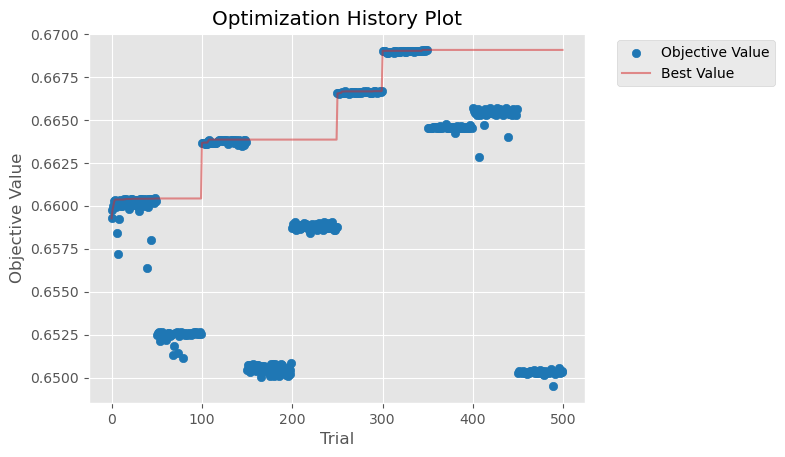

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.681958,0.014563
1,TP,201.300000,7.717944
2,TN,172.300000,6.377913
3,FP,40.800000,6.051630
4,FN,34.800000,4.516636
5,Accuracy,0.831701,0.017220
6,Precision,0.831510,0.024461
7,Sensitivity,0.852611,0.018602
8,Specificity,0.808820,0.025307
9,F1 score,0.841746,0.017514


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.668049,0.674609,0.679188,0.685368,0.668521,0.695704,0.642760,0.641451,0.680583,0.679226,0.671546,0.017444
1,TP,410.000000,406.000000,411.000000,399.000000,411.000000,399.000000,395.000000,405.000000,415.000000,417.000000,406.800000,7.315129
2,TN,341.000000,345.000000,342.000000,338.000000,351.000000,351.000000,341.000000,324.000000,350.000000,340.000000,342.300000,8.028422
3,FP,89.000000,79.000000,86.000000,97.000000,78.000000,80.000000,86.000000,94.000000,66.000000,75.000000,83.000000,9.273618
4,FN,59.000000,69.000000,60.000000,65.000000,59.000000,69.000000,77.000000,76.000000,68.000000,67.000000,66.900000,6.419588
5,Accuracy,0.835373,0.835373,0.837597,0.819800,0.847608,0.834260,0.818687,0.810901,0.850945,0.842047,0.833259,0.012987
6,Precision,0.821643,0.837113,0.826962,0.804435,0.840491,0.832985,0.821206,0.811623,0.862786,0.847561,0.830681,0.017307
7,Sensitivity,0.874200,0.854737,0.872611,0.859914,0.874468,0.852564,0.836864,0.841996,0.859213,0.861570,0.858814,0.012916
8,Specificity,0.793000,0.813700,0.799100,0.777000,0.818200,0.814400,0.798600,0.775100,0.841300,0.819300,0.804970,0.020435
9,F1 score,0.847107,0.845833,0.849174,0.831250,0.857143,0.842661,0.828961,0.826531,0.860996,0.854508,0.844416,0.012045


In [41]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=16, 
                                            random_state=1121218, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
rf_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_rf0,y_pred_rf1,y_pred_rf2,y_pred_rf3,y_pred_rf4,y_pred_rf_ave,y_pred_rf_std
0,CHEMBL4176702,0,6.50,5.505710,5.550615,5.504201,5.511151,5.507655,5.679889,0.367114
1,CHEMBL272401,1,7.26,6.738022,6.743419,6.736271,6.694661,6.803153,6.829254,0.195224
2,CHEMBL118,2,5.93,5.752434,5.660371,5.654286,5.810624,5.741369,5.758181,0.093940
3,CHEMBL3655939,3,6.28,6.581242,6.486131,6.529855,6.499316,6.557200,6.488957,0.098847
4,CHEMBL3621537,4,5.88,5.820532,5.754759,5.696358,5.868528,5.837274,5.809575,0.064737
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL2047606,4487,5.44,5.658968,5.570938,5.530684,5.561325,5.592130,5.559008,0.066083
4488,CHEMBL217781,4488,7.48,6.593201,6.675044,6.627025,6.547151,6.658144,6.763427,0.323195
4489,CHEMBL2105763,4489,9.92,6.836382,6.969534,6.780518,6.903353,6.913074,7.387144,1.134305
4490,CHEMBL3415969,4490,5.75,5.930866,5.934840,6.453162,5.912963,5.907799,5.981605,0.220200


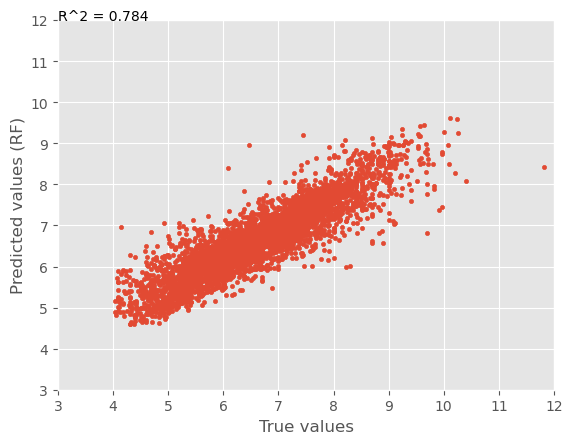

In [42]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (3, 12))
plt.show()

In [43]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.6807 with a standard deviation of 0.0249
RF optimized model r2_score 0.6833 with a standard deviation of 0.0220


In [44]:
joblib.dump(rf_reg, "OUTPUT/rf_reg.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf.joblib")

['OUTPUT/optimizedCV_rf.joblib']

## LGBMRegressor

In [45]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=16,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.669431     0.019571
1                    TP       196.400000     9.731963
2                    TN       170.800000     8.066391
3                    FP        42.300000     5.558777
4                    FN        39.700000     6.147267
5              Accuracy         0.817453     0.022980
6             Precision         0.822612     0.024171
7           Sensitivity         0.831693     0.026979
8           Specificity         0.801480     0.025525
9              F1 score         0.827026     0.023660
10  F1 score (weighted)         0.817385     0.022985
11     F1 score (macro)         0.816685     0.023040
12    Balanced Accuracy         0.816592     0.023082
13                  MCC         0.633654     0.046163
14                  NPV         0.811510     0.027257
15              ROC_AUC         0.816592     0.023082
CPU times: user 29.2 s, sys: 116 ms, total: 29.3 s
Wall time: 1.99 s


In [46]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [47]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=16,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [48]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:09:09,481] A new study created in memory with name: lgbmRegressor
[I 2023-12-11 08:09:10,029] Trial 0 finished with value: 0.258581641115595 and parameters: {'n_estimators': 53, 'learning_rate': 0.0376459149114092, 'max_depth': 3, 'max_bin': 182, 'num_leaves': 733}. Best is trial 0 with value: 0.258581641115595.
[I 2023-12-11 08:09:14,373] Trial 1 finished with value: 0.678998182328582 and parameters: {'n_estimators': 861, 'learning_rate': 0.08590689256589533, 'max_depth': 8, 'max_bin': 244, 'num_leaves': 333}. Best is trial 1 with value: 0.678998182328582.
[I 2023-12-11 08:09:15,520] Trial 2 finished with value: 0.6275799188655113 and parameters: {'n_estimators': 182, 'learning_rate': 0.1848083771432217, 'max_depth': 4, 'max_bin': 276, 'num_leaves': 575}. Best is trial 1 with value: 0.678998182328582.
[I 2023-12-11 08:09:17,670] Trial 3 finished with value: 0.5514356975470378 and parameters: {'n_estimators': 114, 'learning_rate': 0.02199349911976079, 'max_depth': 9, '

	Number of trials: 50.0
	Best value (r2_score): 0.6853
	Best params:
		n_estimators: 895
		learning_rate: 0.026625727379818196
		max_depth: 12
		max_bin: 253
		num_leaves: 718


In [49]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_0_cat = np.where((y_pred_lgbm_0>= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.695789
1                    TP  401.000000
2                    TN  352.000000
3                    FP   78.000000
4                    FN   68.000000
5              Accuracy    0.837597
6             Precision    0.837161
7           Sensitivity    0.855011
8           Specificity    0.818600
9              F1 score    0.845992
10  F1 score (weighted)    0.837499
11     F1 score (macro)    0.837113
12    Balanced Accuracy    0.836808
13                  MCC    0.674435
14                  NPV    0.838100
15              ROC_AUC    0.836808


In [50]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:14:14,440] Trial 50 finished with value: 0.6721625397286283 and parameters: {'n_estimators': 849, 'learning_rate': 0.029127260031190042, 'max_depth': 12, 'max_bin': 155, 'num_leaves': 718}. Best is trial 47 with value: 0.685270435340522.
[I 2023-12-11 08:14:23,443] Trial 51 finished with value: 0.6762718927006469 and parameters: {'n_estimators': 645, 'learning_rate': 0.04312214427637836, 'max_depth': 12, 'max_bin': 267, 'num_leaves': 674}. Best is trial 47 with value: 0.685270435340522.
[I 2023-12-11 08:14:31,224] Trial 52 finished with value: 0.672897685450248 and parameters: {'n_estimators': 770, 'learning_rate': 0.053308804559671255, 'max_depth': 12, 'max_bin': 254, 'num_leaves': 565}. Best is trial 47 with value: 0.685270435340522.
[I 2023-12-11 08:14:40,478] Trial 53 finished with value: 0.6736647953198269 and parameters: {'n_estimators': 706, 'learning_rate': 0.03768260525287426, 'max_depth': 11, 'max_bin': 285, 'num_leaves': 642}. Best is trial 47 with value: 0.

	Number of trials: 100.0
	Best value (r2_score): 0.6853
	Best params:
		n_estimators: 895
		learning_rate: 0.026625727379818196
		max_depth: 12
		max_bin: 253
		num_leaves: 718


In [51]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_1_cat = np.where((y_pred_lgbm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.695789    0.706151
1                    TP  401.000000  393.000000
2                    TN  352.000000  345.000000
3                    FP   78.000000   79.000000
4                    FN   68.000000   82.000000
5              Accuracy    0.837597    0.820912
6             Precision    0.837161    0.832627
7           Sensitivity    0.855011    0.827368
8           Specificity    0.818600    0.813700
9              F1 score    0.845992    0.829989
10  F1 score (weighted)    0.837499    0.820944
11     F1 score (macro)    0.837113    0.820400
12    Balanced Accuracy    0.836808    0.820524
13                  MCC    0.674435    0.640819
14                  NPV    0.838100    0.808000
15              ROC_AUC    0.836808    0.820524


In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:21:25,750] Trial 100 finished with value: 0.6872659012355518 and parameters: {'n_estimators': 742, 'learning_rate': 0.04337819207210719, 'max_depth': 12, 'max_bin': 260, 'num_leaves': 678}. Best is trial 100 with value: 0.6872659012355518.
[I 2023-12-11 08:21:35,018] Trial 101 finished with value: 0.687396873430845 and parameters: {'n_estimators': 694, 'learning_rate': 0.03980544927022812, 'max_depth': 12, 'max_bin': 258, 'num_leaves': 672}. Best is trial 101 with value: 0.687396873430845.
[I 2023-12-11 08:21:44,072] Trial 102 finished with value: 0.6875906748834122 and parameters: {'n_estimators': 692, 'learning_rate': 0.040057039751297284, 'max_depth': 12, 'max_bin': 256, 'num_leaves': 672}. Best is trial 102 with value: 0.6875906748834122.
[I 2023-12-11 08:21:52,849] Trial 103 finished with value: 0.6886170785308964 and parameters: {'n_estimators': 695, 'learning_rate': 0.04408566912417059, 'max_depth': 12, 'max_bin': 252, 'num_leaves': 626}. Best is trial 103 with 

	Number of trials: 150.0
	Best value (r2_score): 0.6912
	Best params:
		n_estimators: 609
		learning_rate: 0.05349456089914068
		max_depth: 12
		max_bin: 222
		num_leaves: 590


In [53]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_2_cat = np.where((y_pred_lgbm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.695789    0.706151    0.690541
1                    TP  401.000000  393.000000  396.000000
2                    TN  352.000000  345.000000  352.000000
3                    FP   78.000000   79.000000   76.000000
4                    FN   68.000000   82.000000   75.000000
5              Accuracy    0.837597    0.820912    0.832036
6             Precision    0.837161    0.832627    0.838983
7           Sensitivity    0.855011    0.827368    0.840764
8           Specificity    0.818600    0.813700    0.822400
9              F1 score    0.845992    0.829989    0.839873
10  F1 score (weighted)    0.837499    0.820944    0.832026
11     F1 score (macro)    0.837113    0.820400    0.831632
12    Balanced Accuracy    0.836808    0.820524    0.831597
13                  MCC    0.674435    0.640819    0.663267
14                  NPV    0.838100    0.808000    0.824400
15              ROC_AUC    0.836808    0

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:27:42,333] Trial 150 finished with value: 0.6698344710730163 and parameters: {'n_estimators': 656, 'learning_rate': 0.05963349511560973, 'max_depth': 12, 'max_bin': 214, 'num_leaves': 695}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:27:49,289] Trial 151 finished with value: 0.6739034074072394 and parameters: {'n_estimators': 539, 'learning_rate': 0.056856292848505754, 'max_depth': 12, 'max_bin': 235, 'num_leaves': 568}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:27:55,802] Trial 152 finished with value: 0.6709750213803043 and parameters: {'n_estimators': 520, 'learning_rate': 0.06677116537389369, 'max_depth': 12, 'max_bin': 234, 'num_leaves': 560}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:28:03,469] Trial 153 finished with value: 0.6711517205588902 and parameters: {'n_estimators': 551, 'learning_rate': 0.051373723857219285, 'max_depth': 12, 'max_bin': 230, 'num_leaves': 579}. Best is trial 117 with 

	Number of trials: 200.0
	Best value (r2_score): 0.6912
	Best params:
		n_estimators: 609
		learning_rate: 0.05349456089914068
		max_depth: 12
		max_bin: 222
		num_leaves: 590


In [55]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.6

y_pred_lgbm_3_cat = np.where((y_pred_lgbm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.695789    0.706151    0.690541    0.727531
1                    TP  401.000000  393.000000  396.000000  399.000000
2                    TN  352.000000  345.000000  352.000000  359.000000
3                    FP   78.000000   79.000000   76.000000   76.000000
4                    FN   68.000000   82.000000   75.000000   65.000000
5              Accuracy    0.837597    0.820912    0.832036    0.843159
6             Precision    0.837161    0.832627    0.838983    0.840000
7           Sensitivity    0.855011    0.827368    0.840764    0.859914
8           Specificity    0.818600    0.813700    0.822400    0.825300
9              F1 score    0.845992    0.829989    0.839873    0.849840
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848
12    Balanced Accuracy    0.836808    0.820524    0.831597    0

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:33:47,454] Trial 200 finished with value: 0.6860809555080868 and parameters: {'n_estimators': 560, 'learning_rate': 0.060369830612370744, 'max_depth': 12, 'max_bin': 233, 'num_leaves': 646}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:33:55,789] Trial 201 finished with value: 0.6891009364784347 and parameters: {'n_estimators': 743, 'learning_rate': 0.043310440163862, 'max_depth': 12, 'max_bin': 265, 'num_leaves': 184}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:34:04,553] Trial 202 finished with value: 0.6877340419234901 and parameters: {'n_estimators': 532, 'learning_rate': 0.04267200934563549, 'max_depth': 12, 'max_bin': 263, 'num_leaves': 309}. Best is trial 117 with value: 0.691221149930741.
[I 2023-12-11 08:34:13,496] Trial 203 finished with value: 0.6870661706542387 and parameters: {'n_estimators': 716, 'learning_rate': 0.04040011328133441, 'max_depth': 12, 'max_bin': 265, 'num_leaves': 179}. Best is trial 117 with val

	Number of trials: 250.0
	Best value (r2_score): 0.6932
	Best params:
		n_estimators: 764
		learning_rate: 0.04742794787391275
		max_depth: 12
		max_bin: 266
		num_leaves: 250


In [57]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.6
 
y_pred_lgbm_4_cat = np.where((y_pred_lgbm_4 >= 6.6) , 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:40:50,724] Trial 250 finished with value: 0.6752738799305706 and parameters: {'n_estimators': 734, 'learning_rate': 0.04339050554221033, 'max_depth': 8, 'max_bin': 263, 'num_leaves': 278}. Best is trial 225 with value: 0.6931625399512271.
[I 2023-12-11 08:41:00,046] Trial 251 finished with value: 0.6872432579869727 and parameters: {'n_estimators': 798, 'learning_rate': 0.05021883726513868, 'max_depth': 12, 'max_bin': 268, 'num_leaves': 235}. Best is trial 225 with value: 0.6931625399512271.
[I 2023-12-11 08:41:09,123] Trial 252 finished with value: 0.6902594060804569 and parameters: {'n_estimators': 784, 'learning_rate': 0.047004682429963224, 'max_depth': 12, 'max_bin': 266, 'num_leaves': 305}. Best is trial 225 with value: 0.6931625399512271.
[I 2023-12-11 08:41:18,391] Trial 253 finished with value: 0.6892009540546838 and parameters: {'n_estimators': 773, 'learning_rate': 0.04592666777337722, 'max_depth': 12, 'max_bin': 266, 'num_leaves': 332}. Best is trial 225 with

	Number of trials: 300.0
	Best value (r2_score): 0.6932
	Best params:
		n_estimators: 764
		learning_rate: 0.04742794787391275
		max_depth: 12
		max_bin: 266
		num_leaves: 250


In [59]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_5_cat = np.where((y_pred_lgbm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:48:26,590] Trial 300 finished with value: 0.694694964431036 and parameters: {'n_estimators': 754, 'learning_rate': 0.051454311577780354, 'max_depth': 12, 'max_bin': 272, 'num_leaves': 293}. Best is trial 300 with value: 0.694694964431036.
[I 2023-12-11 08:48:35,348] Trial 301 finished with value: 0.7007586898439598 and parameters: {'n_estimators': 731, 'learning_rate': 0.04707730020946589, 'max_depth': 12, 'max_bin': 279, 'num_leaves': 312}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:48:40,350] Trial 302 finished with value: 0.6661991152844571 and parameters: {'n_estimators': 724, 'learning_rate': 0.048850921601139616, 'max_depth': 5, 'max_bin': 280, 'num_leaves': 338}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:48:48,304] Trial 303 finished with value: 0.6947626597521925 and parameters: {'n_estimators': 739, 'learning_rate': 0.052428797272437926, 'max_depth': 12, 'max_bin': 276, 'num_leaves': 321}. Best is trial 301 with

	Number of trials: 350.0
	Best value (r2_score): 0.700759
	Best params:
		n_estimators: 731
		learning_rate: 0.04707730020946589
		max_depth: 12
		max_bin: 279
		num_leaves: 312


In [61]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_6_cat = np.where((y_pred_lgbm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:54:17,427] Trial 350 finished with value: 0.6838639511934187 and parameters: {'n_estimators': 672, 'learning_rate': 0.06528852249026602, 'max_depth': 10, 'max_bin': 201, 'num_leaves': 232}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:54:24,116] Trial 351 finished with value: 0.6858789591498551 and parameters: {'n_estimators': 688, 'learning_rate': 0.060708071897859456, 'max_depth': 10, 'max_bin': 195, 'num_leaves': 272}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:54:31,022] Trial 352 finished with value: 0.6878612459020007 and parameters: {'n_estimators': 695, 'learning_rate': 0.06892361259398416, 'max_depth': 10, 'max_bin': 203, 'num_leaves': 263}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:54:37,514] Trial 353 finished with value: 0.6825518410657722 and parameters: {'n_estimators': 660, 'learning_rate': 0.05995613528010262, 'max_depth': 10, 'max_bin': 200, 'num_leaves': 235}. Best is trial 301 wit

	Number of trials: 400.0
	Best value (r2_score): 0.7007587
	Best params:
		n_estimators: 731
		learning_rate: 0.04707730020946589
		max_depth: 12
		max_bin: 279
		num_leaves: 312


In [63]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_7_cat = np.where((y_pred_lgbm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

In [64]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 08:59:26,518] Trial 400 finished with value: 0.6700333861974241 and parameters: {'n_estimators': 658, 'learning_rate': 0.115038316542641, 'max_depth': 10, 'max_bin': 200, 'num_leaves': 251}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:59:32,210] Trial 401 finished with value: 0.6754539518746397 and parameters: {'n_estimators': 678, 'learning_rate': 0.06936220981621219, 'max_depth': 10, 'max_bin': 204, 'num_leaves': 217}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:59:38,431] Trial 402 finished with value: 0.6774414606014706 and parameters: {'n_estimators': 729, 'learning_rate': 0.05376024576482899, 'max_depth': 10, 'max_bin': 209, 'num_leaves': 299}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 08:59:44,343] Trial 403 finished with value: 0.6778648262965451 and parameters: {'n_estimators': 693, 'learning_rate': 0.06518806983603181, 'max_depth': 9, 'max_bin': 198, 'num_leaves': 283}. Best is trial 301 with va

	Number of trials: 450.0
	Best value (r2_score): 0.70075869
	Best params:
		n_estimators: 731
		learning_rate: 0.04707730020946589
		max_depth: 12
		max_bin: 279
		num_leaves: 312


In [65]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_8_cat = np.where((y_pred_lgbm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

In [66]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 09:04:39,928] Trial 450 finished with value: 0.6648738896652363 and parameters: {'n_estimators': 697, 'learning_rate': 0.06571120666060314, 'max_depth': 10, 'max_bin': 204, 'num_leaves': 237}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 09:04:47,241] Trial 451 finished with value: 0.6672454704119997 and parameters: {'n_estimators': 672, 'learning_rate': 0.059273007543624814, 'max_depth': 11, 'max_bin': 208, 'num_leaves': 273}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 09:04:54,218] Trial 452 finished with value: 0.6659788168166845 and parameters: {'n_estimators': 724, 'learning_rate': 0.05503099710583261, 'max_depth': 10, 'max_bin': 198, 'num_leaves': 313}. Best is trial 301 with value: 0.7007586898439598.
[I 2023-12-11 09:04:59,933] Trial 453 finished with value: 0.6564231991703153 and parameters: {'n_estimators': 707, 'learning_rate': 0.06263640211005368, 'max_depth': 6, 'max_bin': 202, 'num_leaves': 288}. Best is trial 301 with

	Number of trials: 500.0
	Best value (r2_score): 0.700758690
	Best params:
		n_estimators: 731
		learning_rate: 0.04707730020946589
		max_depth: 12
		max_bin: 279
		num_leaves: 312


In [67]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=5, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_lgbm_9_cat = np.where((y_pred_lgbm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                           np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.695789    0.706151    0.690541    0.727531   
1                    TP  401.000000  393.000000  396.000000  399.000000   
2                    TN  352.000000  345.000000  352.000000  359.000000   
3                    FP   78.000000   79.000000   76.000000   76.000000   
4                    FN   68.000000   82.000000   75.000000   65.000000   
5              Accuracy    0.837597    0.820912    0.832036    0.843159   
6             Precision    0.837161    0.832627    0.838983    0.840000   
7           Sensitivity    0.855011    0.827368    0.840764    0.859914   
8           Specificity    0.818600    0.813700    0.822400    0.825300   
9              F1 score    0.845992    0.829989    0.839873    0.849840   
10  F1 score (weighted)    0.837499    0.820944    0.832026    0.843074   
11     F1 score (macro)    0.837113    0.820400    0.831632    0.842848   
12    Balanced Accuracy  

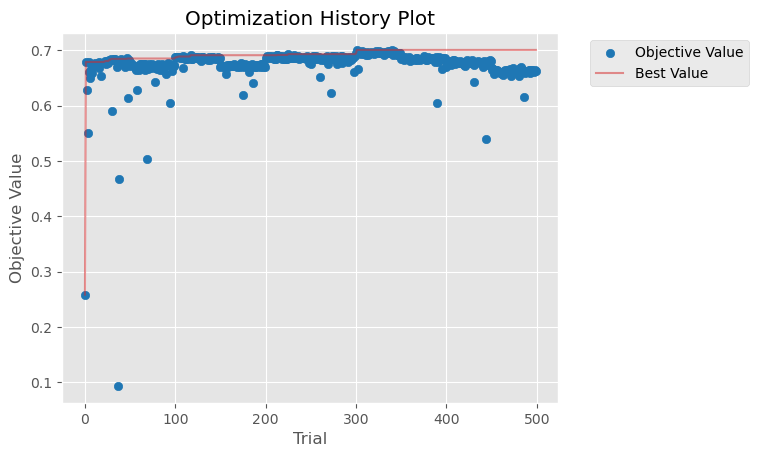

In [68]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

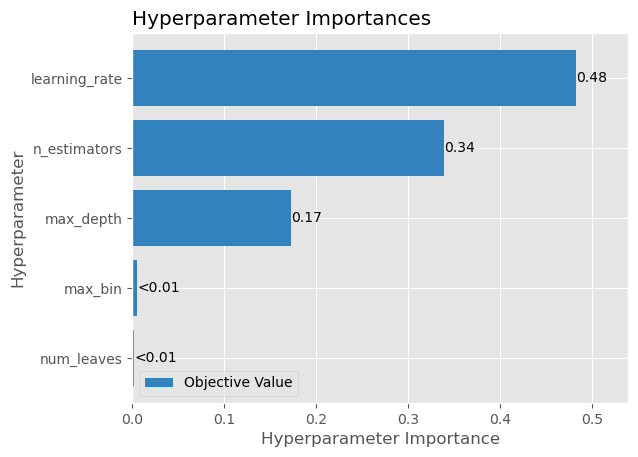

In [69]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [70]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.702515     0.015722
1                    TP       197.600000     7.763161
2                    TN       173.000000     7.859884
3                    FP        40.100000     4.954235
4                    FN        38.500000     4.743416
5              Accuracy         0.825024     0.015305
6             Precision         0.831354     0.019142
7           Sensitivity         0.836934     0.019348
8           Specificity         0.811790     0.022643
9              F1 score         0.833981     0.015303
10  F1 score (weighted)         0.824980     0.015334
11     F1 score (macro)         0.824331     0.015511
12    Balanced Accuracy         0.824363     0.015456
13                  MCC         0.649024     0.030705
14                  NPV         0.817970     0.021125
15              ROC_AUC         0.824363     0.015456


In [71]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.695789,0.706151,0.690541,0.727531,0.688238,0.703452,0.640478,0.665989,0.680979,0.699497,0.689864,0.023776
1,TP,401.000000,393.000000,396.000000,399.000000,400.000000,388.000000,381.000000,391.000000,404.000000,403.000000,395.600000,7.336363
2,TN,352.000000,345.000000,352.000000,359.000000,340.000000,348.000000,357.000000,337.000000,354.000000,350.000000,349.400000,7.058486
3,FP,78.000000,79.000000,76.000000,76.000000,89.000000,83.000000,70.000000,81.000000,62.000000,65.000000,75.900000,8.225300
4,FN,68.000000,82.000000,75.000000,65.000000,70.000000,80.000000,91.000000,90.000000,79.000000,81.000000,78.100000,8.723531
5,Accuracy,0.837597,0.820912,0.832036,0.843159,0.823137,0.818687,0.820912,0.809789,0.843159,0.837597,0.828699,0.011536
6,Precision,0.837161,0.832627,0.838983,0.840000,0.817996,0.823779,0.844789,0.828390,0.866953,0.861111,0.839179,0.015398
7,Sensitivity,0.855011,0.827368,0.840764,0.859914,0.851064,0.829060,0.807203,0.812890,0.836439,0.832645,0.835236,0.017239
8,Specificity,0.818600,0.813700,0.822400,0.825300,0.792500,0.807400,0.836100,0.806200,0.851000,0.843400,0.821660,0.018016
9,F1 score,0.845992,0.829989,0.839873,0.849840,0.834202,0.826411,0.825569,0.820567,0.851423,0.846639,0.837050,0.011179


In [72]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
lgbm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_lgbm0,y_pred_lgbm1,y_pred_lgbm2,y_pred_lgbm3,y_pred_lgbm4,y_pred_lgbm_ave,y_pred_lgbm_std
0,CHEMBL4176702,0,6.50,5.565255,5.705026,5.937393,5.626906,5.809386,5.857328,0.311805
1,CHEMBL272401,1,7.26,7.053297,6.882651,7.022504,6.761797,7.306279,7.047755,0.192173
2,CHEMBL118,2,5.93,5.167096,5.212734,5.329301,5.382758,5.554621,5.429418,0.256328
3,CHEMBL3655939,3,6.28,6.741445,6.797126,6.670764,6.576688,6.699691,6.627619,0.169400
4,CHEMBL3621537,4,5.88,6.284534,6.195729,5.996763,6.128940,6.046171,6.088689,0.132440
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL2047606,4487,5.44,5.663850,5.636298,5.548059,5.630025,5.582576,5.583468,0.074451
4488,CHEMBL217781,4488,7.48,6.800631,6.576407,6.743852,6.419486,6.726066,6.791074,0.332998
4489,CHEMBL2105763,4489,9.92,6.810849,7.434572,7.158416,7.082478,7.098783,7.584183,1.060273
4490,CHEMBL3415969,4490,5.75,6.012308,5.822582,6.470055,6.119471,5.913145,6.014594,0.236509


In [73]:
mat_met_optimized_lgbm

,Metric,Value (average),Value (std)
0,R2,0.705614,0.035978
1,Accuracy,0.831698,0.019330
2,Precision,0.844526,0.025668
3,Sensitivity,0.833358,0.026756
4,Specificity,0.829984,0.028459
5,F1 score,0.838577,0.020226
6,F1 score (weighted),0.831724,0.019373
7,F1 score (macro),0.831146,0.019333
8,Balanced Accuracy,0.831673,0.019537
9,MCC,0.663079,0.038654


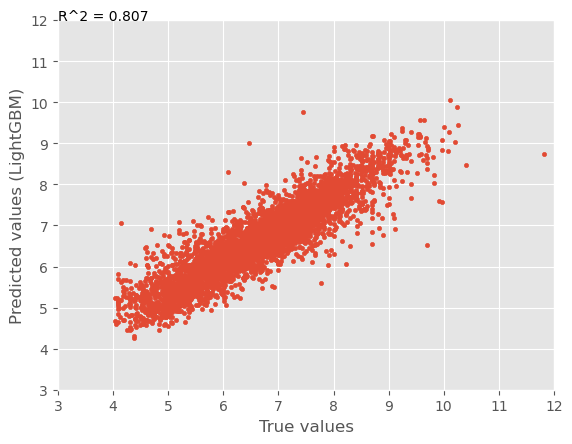

In [74]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (3, 12))
plt.show()

In [75]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.6675 with a standard deviation of 0.0331
LightGBM optimized model r2_score 0.7069 with a standard deviation of 0.0324


In [76]:
joblib.dump(lgbm_reg, "OUTPUT/lgbm_reg.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm.joblib") 


['OUTPUT/optimizedCV_lgbm.joblib']

## XGBoost

In [77]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.661845     0.017506
1                    TP       191.900000     6.244108
2                    TN       171.600000     7.705698
3                    FP        41.500000     5.317685
4                    FN        44.200000     5.921711
5              Accuracy         0.809217     0.019867
6             Precision         0.822236     0.021820
7           Sensitivity         0.813034     0.021449
8           Specificity         0.805260     0.023597
9              F1 score         0.817460     0.018476
10  F1 score (weighted)         0.809300     0.019807
11     F1 score (macro)         0.808713     0.020071
12    Balanced Accuracy         0.809154     0.019750
13                  MCC         0.617816     0.039725
14                  NPV         0.795090     0.027717
15              ROC_AUC         0.809154     0.019750
CPU times: user 30min 56s, sys: 1.41 s, total: 30min 57s
Wall time: 1min 13s


In [78]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [79]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=16, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred>=6.6), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [80]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 09:12:31,194] A new study created in memory with name: XGBRegressor
[I 2023-12-11 09:12:46,863] Trial 0 finished with value: 0.685164478341162 and parameters: {'n_estimators': 887, 'eta': 0.08752799414668098, 'max_depth': 9, 'alpha': 0.5839, 'lambda': 20.43525878904361, 'max_bin': 457}. Best is trial 0 with value: 0.685164478341162.
[I 2023-12-11 09:13:01,924] Trial 1 finished with value: 0.6877969683144108 and parameters: {'n_estimators': 698, 'eta': 0.07135989592336833, 'max_depth': 7, 'alpha': 0.8193, 'lambda': 21.411145306778998, 'max_bin': 479}. Best is trial 1 with value: 0.6877969683144108.
[I 2023-12-11 09:13:04,268] Trial 2 finished with value: 0.33691829221926034 and parameters: {'n_estimators': 87, 'eta': 0.03510633241492115, 'max_depth': 9, 'alpha': 0.36860000000000004, 'lambda': 30.942179430007346, 'max_bin': 288}. Best is trial 1 with value: 0.6877969683144108.
[I 2023-12-11 09:13:14,433] Trial 3 finished with value: 0.6557777849539653 and parameters: {'n_es

	Number of trials: 50.0
	Best value (r2_score): 0.6950
	Best params:
		n_estimators: 900
		eta: 0.04873926601611921
		max_depth: 12
		alpha: 0.9139
		lambda: 15.88205462774893
		max_bin: 336


In [81]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
y_pred_xgb_0_cat = np.where((y_pred_xgb_0 >= 6.6), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.681005
1                    TP  406.000000
2                    TN  353.000000
3                    FP   77.000000
4                    FN   63.000000
5              Accuracy    0.844271
6             Precision    0.840580
7           Sensitivity    0.865672
8           Specificity    0.820900
9              F1 score    0.852941
10  F1 score (weighted)    0.844128
11     F1 score (macro)    0.843728
12    Balanced Accuracy    0.843301
13                  MCC    0.687868
14                  NPV    0.848600
15              ROC_AUC    0.843301


In [82]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 09:26:39,296] Trial 50 finished with value: 0.6870468097487868 and parameters: {'n_estimators': 720, 'eta': 0.051822423764699914, 'max_depth': 12, 'alpha': 0.5429, 'lambda': 13.51954489941021, 'max_bin': 402}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:27:02,766] Trial 51 finished with value: 0.6820498085517771 and parameters: {'n_estimators': 764, 'eta': 0.05591524561038364, 'max_depth': 11, 'alpha': 0.7190000000000001, 'lambda': 13.30062668930453, 'max_bin': 384}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:27:14,888] Trial 52 finished with value: 0.6798546306956098 and parameters: {'n_estimators': 400, 'eta': 0.04797619936349773, 'max_depth': 9, 'alpha': 0.8167000000000001, 'lambda': 11.133198220518537, 'max_bin': 369}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:27:38,724] Trial 53 finished with value: 0.6882350695758063 and parameters: {'n_estimators': 799, 'eta': 0.038526101573035446, 'max_depth': 10

	Number of trials: 100.0
	Best value (r2_score): 0.6950
	Best params:
		n_estimators: 900
		eta: 0.04873926601611921
		max_depth: 12
		alpha: 0.9139
		lambda: 15.88205462774893
		max_bin: 336


In [83]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_1_cat = np.where((y_pred_xgb_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.681005    0.720551
1                    TP  406.000000  405.000000
2                    TN  353.000000  341.000000
3                    FP   77.000000   83.000000
4                    FN   63.000000   70.000000
5              Accuracy    0.844271    0.829811
6             Precision    0.840580    0.829918
7           Sensitivity    0.865672    0.852632
8           Specificity    0.820900    0.804200
9              F1 score    0.852941    0.841121
10  F1 score (weighted)    0.844128    0.829635
11     F1 score (macro)    0.843728    0.828944
12    Balanced Accuracy    0.843301    0.828438
13                  MCC    0.687868    0.658238
14                  NPV    0.848600    0.829700
15              ROC_AUC    0.843301    0.828438


In [84]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 09:42:31,533] Trial 100 finished with value: 0.6887663515931131 and parameters: {'n_estimators': 724, 'eta': 0.067634759316528, 'max_depth': 11, 'alpha': 0.8631000000000001, 'lambda': 14.403601923105843, 'max_bin': 372}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:42:46,996] Trial 101 finished with value: 0.6836247618703425 and parameters: {'n_estimators': 887, 'eta': 0.06477992450501352, 'max_depth': 6, 'alpha': 0.9453, 'lambda': 16.12969013840523, 'max_bin': 270}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:43:03,596] Trial 102 finished with value: 0.6874775531618645 and parameters: {'n_estimators': 849, 'eta': 0.07570869852074036, 'max_depth': 7, 'alpha': 0.9024000000000001, 'lambda': 13.851741965322134, 'max_bin': 286}. Best is trial 42 with value: 0.6950106459270369.
[I 2023-12-11 09:43:24,517] Trial 103 finished with value: 0.6927667692009856 and parameters: {'n_estimators': 868, 'eta': 0.07218091310642459, 'max_depth': 10

	Number of trials: 150.0
	Best value (r2_score): 0.6960
	Best params:
		n_estimators: 886
		eta: 0.03696319715961291
		max_depth: 10
		alpha: 0.887
		lambda: 8.704210740196038
		max_bin: 271


In [85]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_2_cat = np.where((y_pred_xgb_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.681005    0.720551    0.717203
1                    TP  406.000000  405.000000  405.000000
2                    TN  353.000000  341.000000  346.000000
3                    FP   77.000000   83.000000   82.000000
4                    FN   63.000000   70.000000   66.000000
5              Accuracy    0.844271    0.829811    0.835373
6             Precision    0.840580    0.829918    0.831622
7           Sensitivity    0.865672    0.852632    0.859873
8           Specificity    0.820900    0.804200    0.808400
9              F1 score    0.852941    0.841121    0.845511
10  F1 score (weighted)    0.844128    0.829635    0.835180
11     F1 score (macro)    0.843728    0.828944    0.834661
12    Balanced Accuracy    0.843301    0.828438    0.834142
13                  MCC    0.687868    0.658238    0.669854
14                  NPV    0.848600    0.829700    0.839800
15              ROC_AUC    0.843301    0

In [86]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 10:02:42,976] Trial 150 finished with value: 0.6847163155196014 and parameters: {'n_estimators': 899, 'eta': 0.03181335395216623, 'max_depth': 10, 'alpha': 0.9028, 'lambda': 7.145941364849205, 'max_bin': 284}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:03:07,849] Trial 151 finished with value: 0.6814745175493585 and parameters: {'n_estimators': 884, 'eta': 0.029891275433820943, 'max_depth': 10, 'alpha': 0.8524, 'lambda': 5.603943388868274, 'max_bin': 295}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:03:34,601] Trial 152 finished with value: 0.685376553495093 and parameters: {'n_estimators': 889, 'eta': 0.0353654417739092, 'max_depth': 10, 'alpha': 0.9076000000000001, 'lambda': 6.674241129464964, 'max_bin': 289}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:03:59,046] Trial 153 finished with value: 0.6861919137951835 and parameters: {'n_estimators': 883, 'eta': 0.03674410518623947, 'max_depth': 10, 'alpha

	Number of trials: 200.0
	Best value (r2_score): 0.6960
	Best params:
		n_estimators: 886
		eta: 0.03696319715961291
		max_depth: 10
		alpha: 0.887
		lambda: 8.704210740196038
		max_bin: 271


In [87]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_3_cat = np.where((y_pred_xgb_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.681005    0.720551    0.717203    0.721099
1                    TP  406.000000  405.000000  405.000000  405.000000
2                    TN  353.000000  341.000000  346.000000  353.000000
3                    FP   77.000000   83.000000   82.000000   82.000000
4                    FN   63.000000   70.000000   66.000000   59.000000
5              Accuracy    0.844271    0.829811    0.835373    0.843159
6             Precision    0.840580    0.829918    0.831622    0.831622
7           Sensitivity    0.865672    0.852632    0.859873    0.872845
8           Specificity    0.820900    0.804200    0.808400    0.811500
9              F1 score    0.852941    0.841121    0.845511    0.851735
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633
12    Balanced Accuracy    0.843301    0.828438    0.834142    0

In [88]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 10:22:11,936] Trial 200 finished with value: 0.6928979456260301 and parameters: {'n_estimators': 815, 'eta': 0.04637685733783568, 'max_depth': 10, 'alpha': 0.9442, 'lambda': 12.524112704148669, 'max_bin': 290}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:22:36,286] Trial 201 finished with value: 0.6938871183606989 and parameters: {'n_estimators': 866, 'eta': 0.042338087437428625, 'max_depth': 10, 'alpha': 0.812, 'lambda': 8.187203116275633, 'max_bin': 274}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:22:56,442] Trial 202 finished with value: 0.6936367727136132 and parameters: {'n_estimators': 867, 'eta': 0.04033545495525575, 'max_depth': 10, 'alpha': 0.8253, 'lambda': 7.172177114257997, 'max_bin': 271}. Best is trial 141 with value: 0.6959547969799948.
[I 2023-12-11 10:23:18,085] Trial 203 finished with value: 0.6933570788446183 and parameters: {'n_estimators': 868, 'eta': 0.04263693443612798, 'max_depth': 10, 'alpha': 0.7618,

	Number of trials: 250.0
	Best value (r2_score): 0.6965
	Best params:
		n_estimators: 850
		eta: 0.0451693044496368
		max_depth: 10
		alpha: 0.8724000000000001
		lambda: 10.712172814327872
		max_bin: 265


In [89]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_4_cat = np.where((y_pred_xgb_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

In [90]:
len(y_pred_xgb_4_cat)

899

In [91]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 10:41:20,533] Trial 250 finished with value: 0.6932114871082182 and parameters: {'n_estimators': 757, 'eta': 0.04377621372871987, 'max_depth': 10, 'alpha': 0.9181, 'lambda': 15.46880314581436, 'max_bin': 300}. Best is trial 224 with value: 0.6964865595264497.
[I 2023-12-11 10:41:47,232] Trial 251 finished with value: 0.6930812871156461 and parameters: {'n_estimators': 787, 'eta': 0.04475145288574193, 'max_depth': 10, 'alpha': 0.9011, 'lambda': 16.471825337198567, 'max_bin': 294}. Best is trial 224 with value: 0.6964865595264497.
[I 2023-12-11 10:42:13,772] Trial 252 finished with value: 0.6946897116728098 and parameters: {'n_estimators': 768, 'eta': 0.045626263630608115, 'max_depth': 10, 'alpha': 0.9528000000000001, 'lambda': 15.102003228466844, 'max_bin': 303}. Best is trial 224 with value: 0.6964865595264497.
[I 2023-12-11 10:42:41,478] Trial 253 finished with value: 0.6953655516050524 and parameters: {'n_estimators': 767, 'eta': 0.0465848557439525, 'max_depth': 11, 'al

	Number of trials: 300.0
	Best value (r2_score): 0.6976
	Best params:
		n_estimators: 749
		eta: 0.04902999970853683
		max_depth: 11
		alpha: 0.9995
		lambda: 16.605903062060605
		max_bin: 321


In [92]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5

y_pred_xgb_5_cat = np.where((y_pred_xgb_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 11:02:41,888] Trial 300 finished with value: 0.7104506251644054 and parameters: {'n_estimators': 708, 'eta': 0.05760042797200709, 'max_depth': 11, 'alpha': 0.9816, 'lambda': 18.890830013982413, 'max_bin': 340}. Best is trial 300 with value: 0.7104506251644054.
[I 2023-12-11 11:03:08,708] Trial 301 finished with value: 0.7107383063531328 and parameters: {'n_estimators': 686, 'eta': 0.058168925372234524, 'max_depth': 11, 'alpha': 0.9999, 'lambda': 19.394176683760232, 'max_bin': 341}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:03:33,068] Trial 302 finished with value: 0.7056706903022418 and parameters: {'n_estimators': 694, 'eta': 0.057309280784771065, 'max_depth': 11, 'alpha': 0.9983000000000001, 'lambda': 18.78221222463725, 'max_bin': 337}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:03:57,505] Trial 303 finished with value: 0.705031696620104 and parameters: {'n_estimators': 689, 'eta': 0.05593723523532048, 'max_depth': 11, 'a

	Number of trials: 350.0
	Best value (r2_score): 0.7107
	Best params:
		n_estimators: 686
		eta: 0.058168925372234524
		max_depth: 11
		alpha: 0.9999
		lambda: 19.394176683760232
		max_bin: 341


In [94]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_6_cat = np.where((y_pred_xgb_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

In [95]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 11:21:55,681] Trial 350 finished with value: 0.6923780132045267 and parameters: {'n_estimators': 661, 'eta': 0.06339256539582927, 'max_depth': 11, 'alpha': 0.9555, 'lambda': 21.88987280917009, 'max_bin': 367}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:22:18,870] Trial 351 finished with value: 0.6906750701439718 and parameters: {'n_estimators': 636, 'eta': 0.06118103445274438, 'max_depth': 11, 'alpha': 0.9522, 'lambda': 20.31047760388058, 'max_bin': 350}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:22:40,945] Trial 352 finished with value: 0.6907865817382197 and parameters: {'n_estimators': 663, 'eta': 0.06412693896870941, 'max_depth': 11, 'alpha': 0.9313, 'lambda': 21.980173488119362, 'max_bin': 356}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:23:02,402] Trial 353 finished with value: 0.692309764551698 and parameters: {'n_estimators': 574, 'eta': 0.06205234464554331, 'max_depth': 11, 'alpha': 0.5556, 

	Number of trials: 400.0
	Best value (r2_score): 0.7107
	Best params:
		n_estimators: 686
		eta: 0.058168925372234524
		max_depth: 11
		alpha: 0.9999
		lambda: 19.394176683760232
		max_bin: 341


In [96]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
y_pred_xgb_7_cat = np.where((y_pred_xgb_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

In [97]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 11:40:18,968] Trial 400 finished with value: 0.6814138533776274 and parameters: {'n_estimators': 636, 'eta': 0.06042229628935706, 'max_depth': 11, 'alpha': 0.9566, 'lambda': 22.448689801260283, 'max_bin': 343}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:40:37,486] Trial 401 finished with value: 0.6861922638930316 and parameters: {'n_estimators': 650, 'eta': 0.058465762190615445, 'max_depth': 11, 'alpha': 0.9423, 'lambda': 18.040520192468392, 'max_bin': 367}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:40:56,221] Trial 402 finished with value: 0.6866069469963044 and parameters: {'n_estimators': 697, 'eta': 0.06285192957620914, 'max_depth': 11, 'alpha': 0.9794, 'lambda': 19.64514061013442, 'max_bin': 350}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:41:14,328] Trial 403 finished with value: 0.6830196267527466 and parameters: {'n_estimators': 500, 'eta': 0.055523010155438465, 'max_depth': 11, 'alpha': 0.95

	Number of trials: 450.0
	Best value (r2_score): 0.7107
	Best params:
		n_estimators: 686
		eta: 0.058168925372234524
		max_depth: 11
		alpha: 0.9999
		lambda: 19.394176683760232
		max_bin: 341


In [98]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
y_pred_xgb_8_cat = np.where((y_pred_xgb_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

In [99]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 11:56:21,266] Trial 450 finished with value: 0.6783934065450097 and parameters: {'n_estimators': 669, 'eta': 0.058609579700703046, 'max_depth': 11, 'alpha': 0.9999, 'lambda': 20.6705490217405, 'max_bin': 332}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:56:38,911] Trial 451 finished with value: 0.6748816821328416 and parameters: {'n_estimators': 616, 'eta': 0.08421782686194412, 'max_depth': 12, 'alpha': 0.9523, 'lambda': 19.760263499805827, 'max_bin': 341}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:56:55,617] Trial 452 finished with value: 0.6636595341656804 and parameters: {'n_estimators': 705, 'eta': 0.06372251763926923, 'max_depth': 11, 'alpha': 0.9216000000000001, 'lambda': 1.937838182027619, 'max_bin': 348}. Best is trial 301 with value: 0.7107383063531328.
[I 2023-12-11 11:57:18,559] Trial 453 finished with value: 0.6764698965257651 and parameters: {'n_estimators': 647, 'eta': 0.054674957346990884, 'max_depth': 11, 'al

	Number of trials: 500.0
	Best value (r2_score): 0.7107
	Best params:
		n_estimators: 686
		eta: 0.058168925372234524
		max_depth: 11
		alpha: 0.9999
		lambda: 19.394176683760232
		max_bin: 341


In [100]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=5, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_xgb_9_cat = np.where((y_pred_xgb_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681005    0.720551    0.717203    0.721099   
1                    TP  406.000000  405.000000  405.000000  405.000000   
2                    TN  353.000000  341.000000  346.000000  353.000000   
3                    FP   77.000000   83.000000   82.000000   82.000000   
4                    FN   63.000000   70.000000   66.000000   59.000000   
5              Accuracy    0.844271    0.829811    0.835373    0.843159   
6             Precision    0.840580    0.829918    0.831622    0.831622   
7           Sensitivity    0.865672    0.852632    0.859873    0.872845   
8           Specificity    0.820900    0.804200    0.808400    0.811500   
9              F1 score    0.852941    0.841121    0.845511    0.851735   
10  F1 score (weighted)    0.844128    0.829635    0.835180    0.842926   
11     F1 score (macro)    0.843728    0.828944    0.834661    0.842633   
12    Balanced Accuracy  

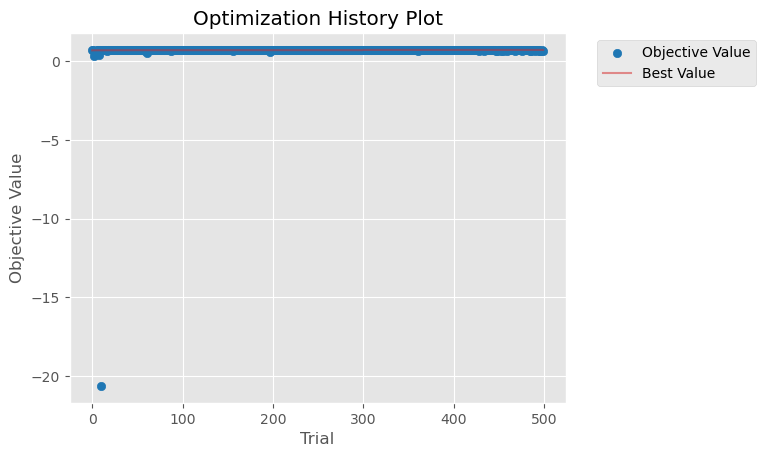

In [101]:
plot_optimization_history(study_xgb);

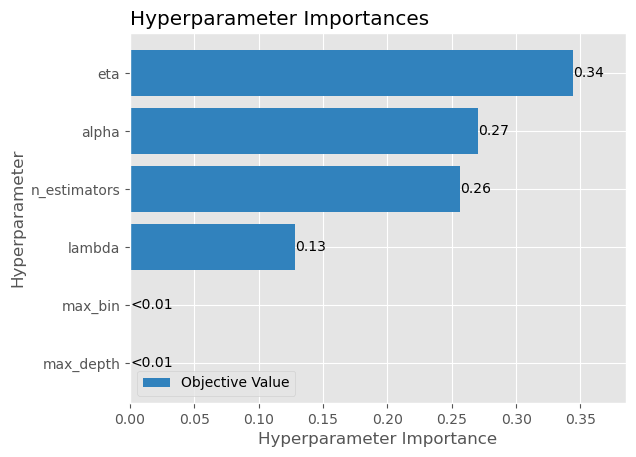

In [102]:
plot_param_importances(study_xgb);

In [103]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.711967,0.020486
1,TP,201.800000,9.554522
2,TN,174.900000,6.951419
3,FP,38.200000,4.237400
4,FN,34.300000,5.396501
5,Accuracy,0.838596,0.017719
6,Precision,0.840614,0.019213
7,Sensitivity,0.854553,0.023977
8,Specificity,0.820780,0.018592
9,F1 score,0.847420,0.019163


In [104]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.681005,0.720551,0.717203,0.721099,0.702278,0.708199,0.649452,0.682835,0.697318,0.708034,0.698798,0.022370
1,TP,406.000000,405.000000,405.000000,405.000000,406.000000,393.000000,395.000000,415.000000,415.000000,407.000000,405.200000,7.067924
2,TN,353.000000,341.000000,346.000000,353.000000,348.000000,353.000000,345.000000,338.000000,349.000000,341.000000,346.700000,5.478240
3,FP,77.000000,83.000000,82.000000,82.000000,81.000000,78.000000,82.000000,80.000000,67.000000,74.000000,78.600000,4.948625
4,FN,63.000000,70.000000,66.000000,59.000000,64.000000,75.000000,77.000000,66.000000,68.000000,77.000000,68.500000,6.168919
5,Accuracy,0.844271,0.829811,0.835373,0.843159,0.838710,0.829811,0.823137,0.837597,0.849833,0.832036,0.836374,0.008012
6,Precision,0.840580,0.829918,0.831622,0.831622,0.833676,0.834395,0.828092,0.838384,0.860996,0.846154,0.837544,0.009869
7,Sensitivity,0.865672,0.852632,0.859873,0.872845,0.863830,0.839744,0.836864,0.862786,0.859213,0.840909,0.855437,0.012366
8,Specificity,0.820900,0.804200,0.808400,0.811500,0.811200,0.819000,0.808000,0.808600,0.838900,0.821700,0.815240,0.010237
9,F1 score,0.852941,0.841121,0.845511,0.851735,0.848485,0.837061,0.832455,0.850410,0.860104,0.843523,0.846335,0.008152


In [105]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=16,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id, xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
xgb_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_xgb0,y_pred_xgb1,y_pred_xgb2,y_pred_xgb3,y_pred_xgb4,y_pred_xgb_ave,y_pred_xgb_std
0,CHEMBL4176702,0,6.50,5.940942,5.841841,5.980500,5.923776,5.865616,6.008779,0.224458
1,CHEMBL272401,1,7.26,7.211039,7.226815,6.982445,6.860160,7.205894,7.124392,0.148884
2,CHEMBL118,2,5.93,5.523479,5.472725,5.347790,5.231540,5.331552,5.472847,0.225605
3,CHEMBL3655939,3,6.28,6.948651,7.021563,6.802073,6.848300,6.799564,6.783359,0.238838
4,CHEMBL3621537,4,5.88,6.336583,6.313459,6.421102,6.643893,6.193159,6.298033,0.231747
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL2047606,4487,5.44,5.577601,5.604442,5.500355,5.612972,5.602675,5.556341,0.064277
4488,CHEMBL217781,4488,7.48,6.779581,6.800874,6.690016,6.884105,6.757020,6.898599,0.266303
4489,CHEMBL2105763,4489,9.92,7.096272,7.166739,6.965294,7.008142,6.948980,7.517571,1.077038
4490,CHEMBL3415969,4490,5.75,5.624371,5.619924,6.255660,5.671523,5.635003,5.759413,0.226291


In [106]:
mat_met_optimized_xgb

,Metric,Value (average),Value (std)
0,R2,0.714164,0.034275
1,Accuracy,0.837089,0.018395
2,Precision,0.839028,0.023966
3,Sensitivity,0.853983,0.026018
4,Specificity,0.818570,0.026507
5,F1 score,0.846134,0.018999
6,F1 score (weighted),0.836981,0.018416
7,F1 score (macro),0.836293,0.018383
8,Balanced Accuracy,0.836275,0.018465
9,MCC,0.673418,0.036808


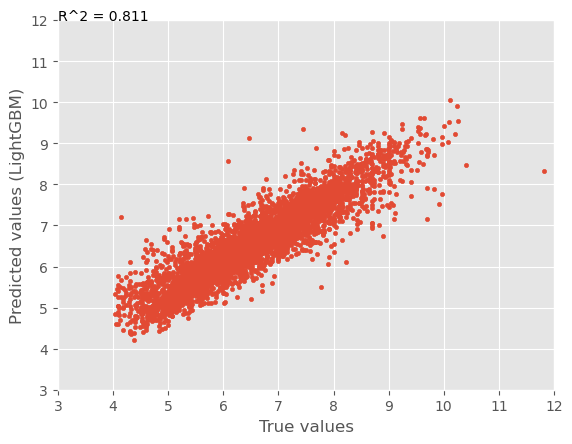

In [107]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (3, 12))
plt.show()

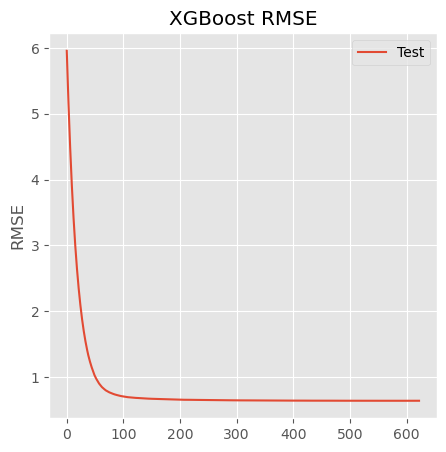

In [108]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [109]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.6616 with a standard deviation of 0.0183
XGBoost optimized model r2_score 0.7139 with a standard deviation of 0.0276


In [110]:
joblib.dump(xgb_reg, "OUTPUT/xgb_reg.joblib")
joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb.joblib")

['OUTPUT/optimizedCV_xgb.joblib']

## KNeighbors (KNN)

In [111]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.648423     0.031385
1                    TP       193.000000     5.142416
2                    TN       169.500000     5.986095
3                    FP        43.600000     4.765618
4                    FN        43.100000     6.026792
5              Accuracy         0.806989     0.008805
6             Precision         0.815939     0.016984
7           Sensitivity         0.817819     0.021253
8           Specificity         0.795600     0.019413
9              F1 score         0.816546     0.008341
10  F1 score (weighted)         0.806987     0.008750
11     F1 score (macro)         0.806359     0.008990
12    Balanced Accuracy         0.806711     0.008763
13                  MCC         0.613460     0.017771
14                  NPV         0.797560     0.024753
15              ROC_AUC         0.806711     0.008763
CPU times: user 5 s, sys: 10.2 s, total: 15.2 s
Wall time: 502 ms


In [112]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [113]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=16)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [114]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:18:51,866] A new study created in memory with name: KNNregressor
[I 2023-12-11 12:18:52,279] Trial 0 finished with value: 0.5933661418330989 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 62}. Best is trial 0 with value: 0.5933661418330989.
[I 2023-12-11 12:18:53,011] Trial 1 finished with value: 0.6199120180174899 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 1 with value: 0.6199120180174899.
[I 2023-12-11 12:18:53,526] Trial 2 finished with value: 0.48578274506187913 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean', 'leaf_size': 53}. Best is trial 1 with value: 0.6199120180174899.
[I 2023-12-11 12:18:54,188] Trial 3 finished with value: 0.5905927293611303 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 96}. Best is trial 1 with value: 0.6199120180174899.
[I 2023-12-11 12:18:54,75

	Number of trials: 50.0
	Best value (r2_score): 0.6473
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 51


In [115]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
y_pred_knn_0_cat = np.where((y_pred_knn_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.647596
1                    TP  393.000000
2                    TN  343.000000
3                    FP   87.000000
4                    FN   76.000000
5              Accuracy    0.818687
6             Precision    0.818750
7           Sensitivity    0.837953
8           Specificity    0.797700
9              F1 score    0.828240
10  F1 score (weighted)    0.818564
11     F1 score (macro)    0.818125
12    Balanced Accuracy    0.817814
13                  MCC    0.636496
14                  NPV    0.818600
15              ROC_AUC    0.817814


In [116]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:19:25,178] Trial 50 finished with value: 0.608945087063453 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 23}. Best is trial 33 with value: 0.6473117695438881.
[I 2023-12-11 12:19:25,891] Trial 51 finished with value: 0.638629406799405 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 46}. Best is trial 33 with value: 0.6473117695438881.
[I 2023-12-11 12:19:26,612] Trial 52 finished with value: 0.6355869296585942 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 53}. Best is trial 33 with value: 0.6473117695438881.
[I 2023-12-11 12:19:27,361] Trial 53 finished with value: 0.6355869296585942 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 59}. Best is trial 33 with value: 0.6473117695438881.
[I 2023-12-11 12:19:28,108] Trial 54 finished with value: 0.5975245814882638 and parameters: {'n_neig

	Number of trials: 100.0
	Best value (r2_score): 0.6473
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 51


In [117]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
y_pred_knn_1_cat = np.where((y_pred_knn_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.647596    0.676203
1                    TP  393.000000  389.000000
2                    TN  343.000000  343.000000
3                    FP   87.000000   81.000000
4                    FN   76.000000   86.000000
5              Accuracy    0.818687    0.814238
6             Precision    0.818750    0.827660
7           Sensitivity    0.837953    0.818947
8           Specificity    0.797700    0.809000
9              F1 score    0.828240    0.823280
10  F1 score (weighted)    0.818564    0.814291
11     F1 score (macro)    0.818125    0.813750
12    Balanced Accuracy    0.817814    0.813955
13                  MCC    0.636496    0.627551
14                  NPV    0.818600    0.799500
15              ROC_AUC    0.817814    0.813955


In [118]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:20:01,150] Trial 100 finished with value: 0.6453911861316908 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 42}. Best is trial 33 with value: 0.6473117695438881.
[I 2023-12-11 12:20:01,855] Trial 101 finished with value: 0.6544509804207109 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 43}. Best is trial 101 with value: 0.6544509804207109.
[I 2023-12-11 12:20:02,508] Trial 102 finished with value: 0.656711662482864 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 42}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:03,214] Trial 103 finished with value: 0.656711662482864 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 43}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:03,926] Trial 104 finished with value: 0.656711662482864 and parameters: {'n_

	Number of trials: 150.0
	Best value (r2_score): 0.6567
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 42


In [119]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
y_pred_knn_2_cat = np.where((y_pred_knn_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.647596    0.676203    0.646090
1                    TP  393.000000  389.000000  399.000000
2                    TN  343.000000  343.000000  341.000000
3                    FP   87.000000   81.000000   87.000000
4                    FN   76.000000   86.000000   72.000000
5              Accuracy    0.818687    0.814238    0.823137
6             Precision    0.818750    0.827660    0.820988
7           Sensitivity    0.837953    0.818947    0.847134
8           Specificity    0.797700    0.809000    0.796700
9              F1 score    0.828240    0.823280    0.833856
10  F1 score (weighted)    0.818564    0.814291    0.822946
11     F1 score (macro)    0.818125    0.813750    0.822398
12    Balanced Accuracy    0.817814    0.813955    0.821931
13                  MCC    0.636496    0.627551    0.645257
14                  NPV    0.818600    0.799500    0.825700
15              ROC_AUC    0.817814    0

In [120]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:20:37,263] Trial 150 finished with value: 0.6334760802152195 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 49}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:37,990] Trial 151 finished with value: 0.6354432456416644 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 38}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:38,736] Trial 152 finished with value: 0.6354432456416644 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 42}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:39,470] Trial 153 finished with value: 0.6354432456416644 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 38}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:20:40,215] Trial 154 finished with value: 0.6365890927302544 and parameters: {'

	Number of trials: 200.0
	Best value (r2_score): 0.6567
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 42


In [121]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
y_pred_knn_3_cat = np.where((y_pred_knn_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.647596    0.676203    0.646090    0.662056
1                    TP  393.000000  389.000000  399.000000  397.000000
2                    TN  343.000000  343.000000  341.000000  348.000000
3                    FP   87.000000   81.000000   87.000000   87.000000
4                    FN   76.000000   86.000000   72.000000   67.000000
5              Accuracy    0.818687    0.814238    0.823137    0.828699
6             Precision    0.818750    0.827660    0.820988    0.820248
7           Sensitivity    0.837953    0.818947    0.847134    0.855603
8           Specificity    0.797700    0.809000    0.796700    0.800000
9              F1 score    0.828240    0.823280    0.833856    0.837553
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188
12    Balanced Accuracy    0.817814    0.813955    0.821931    0

In [122]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:21:13,516] Trial 200 finished with value: 0.6475117773430408 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 41}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:14,186] Trial 201 finished with value: 0.648111347260625 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 38}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:14,851] Trial 202 finished with value: 0.648111347260625 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 36}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:15,499] Trial 203 finished with value: 0.648111347260625 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 33}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:16,172] Trial 204 finished with value: 0.6481759362181269 and parameters: {'n_n

	Number of trials: 250.0
	Best value (r2_score): 0.6567
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 42


In [123]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
y_pred_knn_4_cat = np.where((y_pred_knn_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

In [124]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:21:48,635] Trial 250 finished with value: 0.6466783462183859 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 33}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:49,344] Trial 251 finished with value: 0.6499769426661457 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 42}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:50,036] Trial 252 finished with value: 0.6502159040228671 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 40}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:50,768] Trial 253 finished with value: 0.6466783462183859 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 38}. Best is trial 102 with value: 0.656711662482864.
[I 2023-12-11 12:21:51,357] Trial 254 finished with value: 0.6433728038030322 and parameters: {'

	Number of trials: 300.0
	Best value (r2_score): 0.6567
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 42


In [125]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
y_pred_knn_5_cat = np.where((y_pred_knn_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

In [126]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:22:24,595] Trial 300 finished with value: 0.6621831357765847 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 67}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:25,292] Trial 301 finished with value: 0.6621831357765847 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 58}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:25,940] Trial 302 finished with value: 0.6621831357765847 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 50}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:26,579] Trial 303 finished with value: 0.6621831357765847 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 69}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:27,216] Trial 304 finished with value: 0.6621831357765847 and parameters

	Number of trials: 350.0
	Best value (r2_score): 0.6622
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 67


In [127]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
y_pred_knn_6_cat = np.where((y_pred_knn_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

In [128]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:22:56,115] Trial 350 finished with value: 0.6487187856881974 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 75}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:56,767] Trial 351 finished with value: 0.6487187856881974 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 69}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:57,532] Trial 352 finished with value: 0.6487187856881974 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 74}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:58,602] Trial 353 finished with value: 0.6487187856881974 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 72}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:22:59,259] Trial 354 finished with value: 0.6487187856881974 and parameters

	Number of trials: 400.0
	Best value (r2_score): 0.6622
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 67


In [129]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
y_pred_knn_7_cat = np.where((y_pred_knn_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

In [130]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:23:30,732] Trial 400 finished with value: 0.6432952463720666 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 74}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:23:31,476] Trial 401 finished with value: 0.645597591117324 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 77}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:23:32,172] Trial 402 finished with value: 0.6410406895810925 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 71}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:23:32,719] Trial 403 finished with value: 0.6423202408990953 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 67}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:23:33,449] Trial 404 finished with value: 0.6432952463720666 and parameters:

	Number of trials: 450.0
	Best value (r2_score): 0.6622
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 67


In [131]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
y_pred_knn_8_cat = np.where((y_pred_knn_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

In [132]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:24:05,695] Trial 450 finished with value: 0.5268400779584783 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 76}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:24:06,329] Trial 451 finished with value: 0.6268926834019318 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 71}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:24:07,071] Trial 452 finished with value: 0.6295881952517958 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 73}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:24:07,735] Trial 453 finished with value: 0.6341086734062324 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 69}. Best is trial 300 with value: 0.6621831357765847.
[I 2023-12-11 12:24:08,453] Trial 454 finished with value: 0.6295881952517958 and parameters

	Number of trials: 500.0
	Best value (r2_score): 0.6622
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 67


In [133]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
y_pred_knn_9_cat = np.where((y_pred_knn_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.647596    0.676203    0.646090    0.662056   
1                    TP  393.000000  389.000000  399.000000  397.000000   
2                    TN  343.000000  343.000000  341.000000  348.000000   
3                    FP   87.000000   81.000000   87.000000   87.000000   
4                    FN   76.000000   86.000000   72.000000   67.000000   
5              Accuracy    0.818687    0.814238    0.823137    0.828699   
6             Precision    0.818750    0.827660    0.820988    0.820248   
7           Sensitivity    0.837953    0.818947    0.847134    0.855603   
8           Specificity    0.797700    0.809000    0.796700    0.800000   
9              F1 score    0.828240    0.823280    0.833856    0.837553   
10  F1 score (weighted)    0.818564    0.814291    0.822946    0.828490   
11     F1 score (macro)    0.818125    0.813750    0.822398    0.828188   
12    Balanced Accuracy  

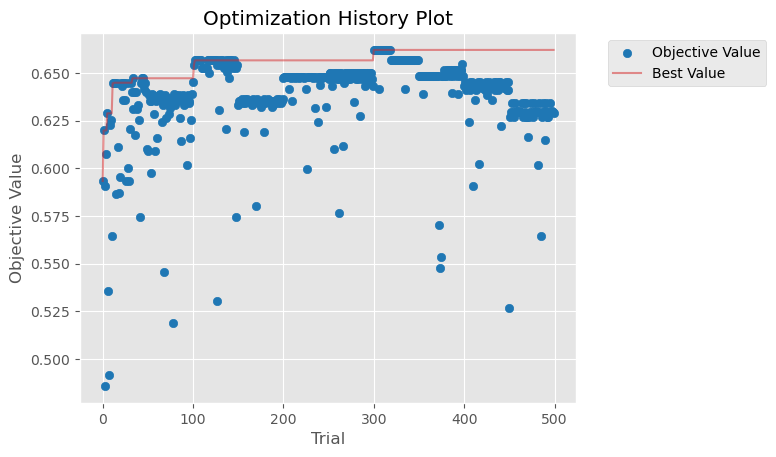

In [134]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

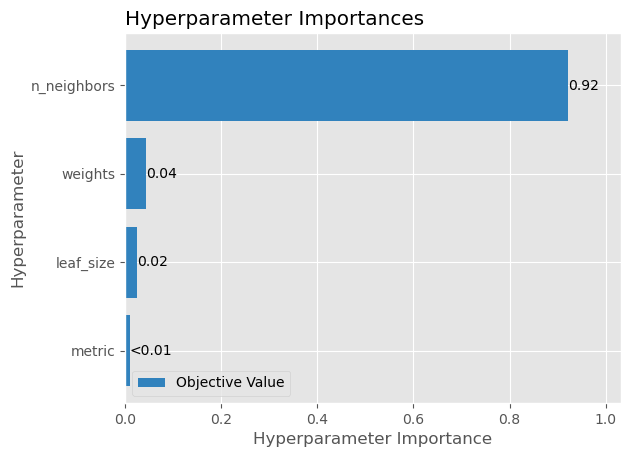

In [135]:

plot_param_importances(study_knn);

In [136]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.658134,0.032933
1,TP,195.600000,6.866990
2,TN,171.600000,6.535374
3,FP,41.500000,3.865805
4,FN,40.500000,3.894440
5,Accuracy,0.817453,0.008723
6,Precision,0.824971,0.015546
7,Sensitivity,0.828512,0.014777
8,Specificity,0.805320,0.016214
9,F1 score,0.826589,0.009589


In [137]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.647596,0.676203,0.646090,0.662056,0.650331,0.670738,0.612010,0.623967,0.640500,0.667519,0.649701,0.020549
1,TP,393.000000,389.000000,399.000000,397.000000,383.000000,382.000000,374.000000,384.000000,407.000000,403.000000,391.100000,10.492855
2,TN,343.000000,343.000000,341.000000,348.000000,351.000000,344.000000,354.000000,327.000000,338.000000,341.000000,343.000000,7.453560
3,FP,87.000000,81.000000,87.000000,87.000000,78.000000,87.000000,73.000000,91.000000,78.000000,74.000000,82.300000,6.307843
4,FN,76.000000,86.000000,72.000000,67.000000,87.000000,86.000000,98.000000,97.000000,76.000000,81.000000,82.600000,10.178409
5,Accuracy,0.818687,0.814238,0.823137,0.828699,0.816463,0.807564,0.809789,0.790879,0.828699,0.827586,0.816574,0.011812
6,Precision,0.818750,0.827660,0.820988,0.820248,0.830803,0.814499,0.836689,0.808421,0.839175,0.844864,0.826210,0.011648
7,Sensitivity,0.837953,0.818947,0.847134,0.855603,0.814894,0.816239,0.792373,0.798337,0.842650,0.832645,0.825678,0.020951
8,Specificity,0.797700,0.809000,0.796700,0.800000,0.818200,0.798100,0.829000,0.782300,0.812500,0.821700,0.806520,0.014096
9,F1 score,0.828240,0.823280,0.833856,0.837553,0.822771,0.815368,0.813928,0.803347,0.840909,0.838710,0.825796,0.012353


In [138]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=16,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 

knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id, knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4176702,0,6.50,6.222504,6.222504,6.222504,6.158350,6.334348,6.276702,0.112550
1,CHEMBL272401,1,7.26,7.461916,7.461916,7.461916,7.172578,7.461916,7.380040,0.118508
2,CHEMBL118,2,5.93,6.041041,6.132011,6.076076,6.033050,6.033050,6.040871,0.060499
3,CHEMBL3655939,3,6.28,6.713693,6.713693,6.714544,6.713693,6.960928,6.682758,0.201442
4,CHEMBL3621537,4,5.88,7.679700,7.168095,6.627393,6.969395,6.627393,6.825329,0.553805
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL2047606,4487,5.44,5.720983,5.537764,5.537764,5.537764,5.537764,5.552007,0.083576
4488,CHEMBL217781,4488,7.48,6.994105,6.994105,6.994105,6.994105,6.994105,7.075088,0.181082
4489,CHEMBL2105763,4489,9.92,6.835557,6.646484,6.646484,6.849567,6.835557,7.288942,1.179840
4490,CHEMBL3415969,4490,5.75,5.560000,5.560000,5.944204,5.560000,5.560000,5.655701,0.146493


In [139]:
mat_met_optimized_knn

,Metric,Value (average),Value (std)
0,R2,0.662777,0.040381
1,Accuracy,0.819323,0.016878
2,Precision,0.828496,0.023371
3,Sensitivity,0.827605,0.021054
4,Specificity,0.810262,0.025108
5,F1 score,0.827822,0.017333
6,F1 score (weighted),0.819328,0.016896
7,F1 score (macro),0.818651,0.016863
8,Balanced Accuracy,0.818932,0.016994
9,MCC,0.637805,0.033800


In [140]:
mat_met_optimized_knn.to_csv('mat_met_knn_opt.csv')
knn_5preds.to_csv('knn_5test_CV_result.csv')

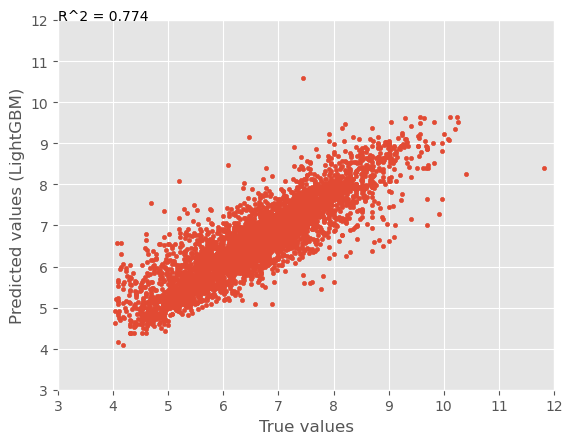

In [141]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (3, 12))
plt.show()

In [142]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6533 with a standard deviation of 0.0380
KNN optimized model r2_score 0.6641 with a standard deviation of 0.0342


In [143]:
joblib.dump(knn_reg, "OUTPUT/knn_reg.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn.joblib")

['OUTPUT/optimizedCV_knn.joblib']

## Support Vector 

In [144]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.6
    y_test_cat = np.where((y_test>=6.6), 1, 0) 
    y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.686083     0.020023
1                    TP       200.400000     7.604092
2                    TN       174.000000     7.055337
3                    FP        39.100000     4.653553
4                    FN        35.700000     5.121849
5              Accuracy         0.833481     0.018352
6             Precision         0.836625     0.020452
7           Sensitivity         0.848852     0.020438
8           Specificity         0.816580     0.020096
9              F1 score         0.842600     0.018162
10  F1 score (weighted)         0.833430     0.018308
11     F1 score (macro)         0.832790     0.018460
12    Balanced Accuracy         0.832712     0.018275
13                  MCC         0.665886     0.036958
14                  NPV         0.829720     0.024651
15              ROC_AUC         0.832712     0.018275
CPU times: user 37.1 s, sys: 20 ms, total: 37.2 s
Wall time: 37.2 s


In [145]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [146]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.6
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_cat = np.where((y_pred >= 6.6), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [147]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:25:27,752] A new study created in memory with name: SVM_regressor_CV
[I 2023-12-11 12:25:46,139] Trial 0 finished with value: 0.003862857892464744 and parameters: {'C': 0.03125, 'gamma': 0.25}. Best is trial 0 with value: 0.003862857892464744.
[I 2023-12-11 12:26:08,572] Trial 1 finished with value: 0.030823057269553377 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 1 with value: 0.030823057269553377.
[I 2023-12-11 12:26:26,825] Trial 2 finished with value: -0.0008844952818438778 and parameters: {'C': 0.0078125, 'gamma': 3.0517578125e-05}. Best is trial 1 with value: 0.030823057269553377.
[I 2023-12-11 12:26:46,872] Trial 3 finished with value: 0.2825359236349435 and parameters: {'C': 64.0, 'gamma': 0.125}. Best is trial 3 with value: 0.2825359236349435.
[I 2023-12-11 12:27:03,476] Trial 4 finished with value: 0.688072636008774 and parameters: {'C': 2.0, 'gamma': 0.015625}. Best is trial 4 with value: 0.688072636008774.
[I 2023-12-11 12:27:22,847] Trial 5 fini

	Number of trials: 50.0
	Best value (r2_score): 0.6889
	Best params:
		C: 32.0
		gamma: 0.015625


In [148]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_0_cat = np.where((y_pred_svm_0 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.698260
1                    TP  395.000000
2                    TN  351.000000
3                    FP   79.000000
4                    FN   74.000000
5              Accuracy    0.829811
6             Precision    0.833333
7           Sensitivity    0.842217
8           Specificity    0.816300
9              F1 score    0.837752
10  F1 score (weighted)    0.829764
11     F1 score (macro)    0.829402
12    Balanced Accuracy    0.829248
13                  MCC    0.658856
14                  NPV    0.825900
15              ROC_AUC    0.829248


In [149]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:42:30,354] Trial 50 finished with value: 0.6721198448143058 and parameters: {'C': 8.0, 'gamma': 0.03125}. Best is trial 29 with value: 0.6888701615496149.
[I 2023-12-11 12:42:49,851] Trial 51 finished with value: 0.6854215282076999 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 29 with value: 0.6888701615496149.
[I 2023-12-11 12:43:09,252] Trial 52 finished with value: 0.6854215282076999 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 29 with value: 0.6888701615496149.
[I 2023-12-11 12:43:28,787] Trial 53 finished with value: 0.6854215282076999 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 29 with value: 0.6888701615496149.
[I 2023-12-11 12:43:48,101] Trial 54 finished with value: 0.6139975682619869 and parameters: {'C': 0.5, 'gamma': 0.015625}. Best is trial 29 with value: 0.6888701615496149.
[I 2023-12-11 12:44:08,389] Trial 55 finished with value: 0.3337492345793757 and parameters: {'C': 1.0, 'gamma': 0.00048828125}. Best

	Number of trials: 100.0
	Best value (r2_score): 0.6927
	Best params:
		C: 4.0
		gamma: 0.015625


In [150]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_1_cat = np.where((y_pred_svm_1 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.698260    0.719248
1                    TP  395.000000  406.000000
2                    TN  351.000000  340.000000
3                    FP   79.000000   84.000000
4                    FN   74.000000   69.000000
5              Accuracy    0.829811    0.829811
6             Precision    0.833333    0.828571
7           Sensitivity    0.842217    0.854737
8           Specificity    0.816300    0.801900
9              F1 score    0.837752    0.841451
10  F1 score (weighted)    0.829764    0.829601
11     F1 score (macro)    0.829402    0.828889
12    Balanced Accuracy    0.829248    0.828312
13                  MCC    0.658856    0.658243
14                  NPV    0.825900    0.831300
15              ROC_AUC    0.829248    0.828312


In [151]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 12:59:32,256] Trial 100 finished with value: 0.03172124697209684 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 60 with value: 0.6927384155239443.
[I 2023-12-11 12:59:52,953] Trial 101 finished with value: 0.6976081712310384 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:00:14,198] Trial 102 finished with value: 0.6976081712310384 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:00:34,629] Trial 103 finished with value: 0.6976081712310384 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:00:55,434] Trial 104 finished with value: 0.6976081712310384 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:01:16,087] Trial 105 finished with value: 0.16639326127881943 and parameters: {'C': 4.0, 'gamma': 3.0517578125e-0

	Number of trials: 150.0
	Best value (r2_score): 0.6976
	Best params:
		C: 4.0
		gamma: 0.015625


In [152]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_2_cat = np.where((y_pred_svm_2 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.698260    0.719248    0.692609
1                    TP  395.000000  406.000000  398.000000
2                    TN  351.000000  340.000000  355.000000
3                    FP   79.000000   84.000000   73.000000
4                    FN   74.000000   69.000000   73.000000
5              Accuracy    0.829811    0.829811    0.837597
6             Precision    0.833333    0.828571    0.845011
7           Sensitivity    0.842217    0.854737    0.845011
8           Specificity    0.816300    0.801900    0.829400
9              F1 score    0.837752    0.841451    0.845011
10  F1 score (weighted)    0.829764    0.829601    0.837597
11     F1 score (macro)    0.829402    0.828889    0.837225
12    Balanced Accuracy    0.829248    0.828312    0.837225
13                  MCC    0.658856    0.658243    0.674450
14                  NPV    0.825900    0.831300    0.829400
15              ROC_AUC    0.829248    0

In [153]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 13:15:49,454] Trial 150 finished with value: 0.6834558423301832 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:16:07,468] Trial 151 finished with value: 0.6834558423301832 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:16:30,034] Trial 152 finished with value: 0.03188011163395045 and parameters: {'C': 4.0, 'gamma': 8.0}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:16:47,954] Trial 153 finished with value: 0.6834558423301832 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:17:06,832] Trial 154 finished with value: 0.16577974854502225 and parameters: {'C': 4.0, 'gamma': 3.0517578125e-05}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:17:25,704] Trial 155 finished with value: 0.31505158354922047 and parameters: {'C': 0.0625, 'gamma': 0.

	Number of trials: 200.0
	Best value (r2_score): 0.6976
	Best params:
		C: 4.0
		gamma: 0.015625


In [154]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_3_cat = np.where((y_pred_svm_3 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.698260    0.719248    0.692609    0.738147
1                    TP  395.000000  406.000000  398.000000  402.000000
2                    TN  351.000000  340.000000  355.000000  353.000000
3                    FP   79.000000   84.000000   73.000000   82.000000
4                    FN   74.000000   69.000000   73.000000   62.000000
5              Accuracy    0.829811    0.829811    0.837597    0.839822
6             Precision    0.833333    0.828571    0.845011    0.830579
7           Sensitivity    0.842217    0.854737    0.845011    0.866379
8           Specificity    0.816300    0.801900    0.829400    0.811500
9              F1 score    0.837752    0.841451    0.845011    0.848101
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345
12    Balanced Accuracy    0.829248    0.828312    0.837225    0

In [155]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 13:31:06,412] Trial 200 finished with value: 0.031088212487045873 and parameters: {'C': 16.0, 'gamma': 8.0}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:31:23,899] Trial 201 finished with value: 0.5411635494817346 and parameters: {'C': 4.0, 'gamma': 0.0009765625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:31:42,383] Trial 202 finished with value: 0.6974213830551494 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:32:00,976] Trial 203 finished with value: 0.6974213830551494 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:32:19,659] Trial 204 finished with value: 0.6974213830551494 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:32:38,081] Trial 205 finished with value: 0.6974213830551494 and parameters: {'C': 4.0, 'gamma': 0.015625}

	Number of trials: 250.0
	Best value (r2_score): 0.6976
	Best params:
		C: 4.0
		gamma: 0.015625


In [156]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_4_cat = np.where((y_pred_svm_4 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [157]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 13:46:28,137] Trial 250 finished with value: 0.6947844419788056 and parameters: {'C': 4.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:46:47,761] Trial 251 finished with value: 0.3152388373857279 and parameters: {'C': 0.0625, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:47:06,798] Trial 252 finished with value: 0.4112508763901469 and parameters: {'C': 4.0, 'gamma': 0.000244140625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:47:25,825] Trial 253 finished with value: 0.5322550390910257 and parameters: {'C': 4.0, 'gamma': 0.0009765625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:47:43,578] Trial 254 finished with value: 0.42288448691791364 and parameters: {'C': 0.125, 'gamma': 0.015625}. Best is trial 101 with value: 0.6976081712310384.
[I 2023-12-11 13:48:02,038] Trial 255 finished with value: 0.6947844419788056 and parameters: {'C': 4.0, 'gam

	Number of trials: 300.0
	Best value (r2_score): 0.6976
	Best params:
		C: 4.0
		gamma: 0.015625


In [158]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_5_cat = np.where((y_pred_svm_5 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [159]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 14:02:03,206] Trial 300 finished with value: 0.7036935515633165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:02:21,154] Trial 301 finished with value: 0.7036935515633165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:02:42,602] Trial 302 finished with value: 0.03258532180058018 and parameters: {'C': 2.0, 'gamma': 8.0}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:03:00,737] Trial 303 finished with value: 0.7036935515633165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:03:17,731] Trial 304 finished with value: 0.4801140025269125 and parameters: {'C': 64.0, 'gamma': 3.0517578125e-05}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:03:36,025] Trial 305 finished with value: 0.7036935515633165 and parameters: {'C': 64.0, 'gamma': 0.

	Number of trials: 350.0
	Best value (r2_score): 0.7037
	Best params:
		C: 64.0
		gamma: 0.015625


In [160]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_6_cat = np.where((y_pred_svm_6 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [161]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 14:18:38,441] Trial 350 finished with value: 0.5496652026344526 and parameters: {'C': 64.0, 'gamma': 0.000244140625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:18:57,860] Trial 351 finished with value: 0.6972571219259099 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:19:17,112] Trial 352 finished with value: 0.6972571219259099 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:19:38,408] Trial 353 finished with value: 0.04638994815452334 and parameters: {'C': 64.0, 'gamma': 1.0}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:19:58,255] Trial 354 finished with value: 0.6972571219259099 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:20:22,197] Trial 355 finished with value: 0.03700855644114857 and parameters: {'C': 64.0, 'gamma': 8.

	Number of trials: 400.0
	Best value (r2_score): 0.7037
	Best params:
		C: 64.0
		gamma: 0.015625


In [162]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_7_cat = np.where((y_pred_svm_7 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [163]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 14:34:53,231] Trial 400 finished with value: 0.6844742843222165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:35:11,720] Trial 401 finished with value: 0.6844742843222165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:35:32,595] Trial 402 finished with value: 0.0311197090345506 and parameters: {'C': 64.0, 'gamma': 8.0}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:35:51,047] Trial 403 finished with value: 0.6844742843222165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:36:09,781] Trial 404 finished with value: 0.6844742843222165 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:36:27,632] Trial 405 finished with value: 0.28133558905514466 and parameters: {'C': 64.0, 'gamma': 0.125}. B

	Number of trials: 450.0
	Best value (r2_score): 0.7037
	Best params:
		C: 64.0
		gamma: 0.015625


In [164]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_8_cat = np.where((y_pred_svm_8 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [165]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-11 14:50:39,444] Trial 450 finished with value: 0.6755801063837289 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:50:59,212] Trial 451 finished with value: 0.6510024965618937 and parameters: {'C': 64.0, 'gamma': 0.0078125}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:51:18,026] Trial 452 finished with value: 0.6755801063837289 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:51:34,910] Trial 453 finished with value: 0.6497890081040494 and parameters: {'C': 1.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:51:53,122] Trial 454 finished with value: 0.6755801063837289 and parameters: {'C': 64.0, 'gamma': 0.015625}. Best is trial 300 with value: 0.7036935515633165.
[I 2023-12-11 14:52:13,427] Trial 455 finished with value: 0.03371436896582053 and parameters: {'C': 64.0, 'gamma': 2.0}

	Number of trials: 500.0
	Best value (r2_score): 0.7037
	Best params:
		C: 64.0
		gamma: 0.015625


In [166]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.6
y_pred_svm_9_cat = np.where((y_pred_svm_9 >= 6.6), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.698260    0.719248    0.692609    0.738147   
1                    TP  395.000000  406.000000  398.000000  402.000000   
2                    TN  351.000000  340.000000  355.000000  353.000000   
3                    FP   79.000000   84.000000   73.000000   82.000000   
4                    FN   74.000000   69.000000   73.000000   62.000000   
5              Accuracy    0.829811    0.829811    0.837597    0.839822   
6             Precision    0.833333    0.828571    0.845011    0.830579   
7           Sensitivity    0.842217    0.854737    0.845011    0.866379   
8           Specificity    0.816300    0.801900    0.829400    0.811500   
9              F1 score    0.837752    0.841451    0.845011    0.848101   
10  F1 score (weighted)    0.829764    0.829601    0.837597    0.839627   
11     F1 score (macro)    0.829402    0.828889    0.837225    0.839345   
12    Balanced Accuracy  

In [167]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7037
	Best params:
		C: 64.0
		gamma: 0.015625


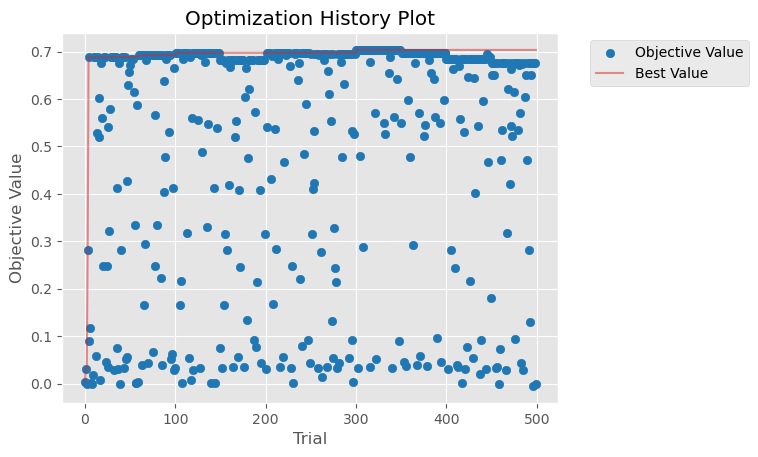

In [168]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [169]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [170]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.709371,0.019467
1,TP,199.900000,7.460265
2,TN,174.400000,7.244922
3,FP,38.700000,6.111010
4,FN,36.200000,5.202563
5,Accuracy,0.833260,0.018840
6,Precision,0.837906,0.025346
7,Sensitivity,0.846757,0.020740
8,Specificity,0.818590,0.026898
9,F1 score,0.842113,0.018580


In [171]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.698260,0.719248,0.692609,0.738147,0.701272,0.724369,0.657130,0.682070,0.706967,0.707509,0.702758,0.022772
1,TP,395.000000,406.000000,398.000000,402.000000,410.000000,392.000000,398.000000,402.000000,416.000000,408.000000,402.700000,7.364328
2,TN,351.000000,340.000000,355.000000,353.000000,346.000000,350.000000,351.000000,334.000000,352.000000,350.000000,348.200000,6.494442
3,FP,79.000000,84.000000,73.000000,82.000000,83.000000,81.000000,76.000000,84.000000,64.000000,65.000000,77.100000,7.519604
4,FN,74.000000,69.000000,73.000000,62.000000,60.000000,76.000000,74.000000,79.000000,67.000000,76.000000,71.000000,6.306963
5,Accuracy,0.829811,0.829811,0.837597,0.839822,0.840934,0.825362,0.833148,0.818687,0.854283,0.843159,0.835261,0.010106
6,Precision,0.833333,0.828571,0.845011,0.830579,0.831643,0.828753,0.839662,0.827160,0.866667,0.862579,0.839396,0.014405
7,Sensitivity,0.842217,0.854737,0.845011,0.866379,0.872340,0.837607,0.843220,0.835759,0.861284,0.842975,0.850153,0.012711
8,Specificity,0.816300,0.801900,0.829400,0.811500,0.806500,0.812100,0.822000,0.799000,0.846200,0.843400,0.818830,0.016370
9,F1 score,0.837752,0.841451,0.845011,0.848101,0.851506,0.833156,0.841438,0.831437,0.863967,0.852665,0.844648,0.009839


In [172]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 



svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id, svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL4176702,0,6.50,6.047977,6.055991,6.127658,6.053485,6.059681,6.140799,0.162896
1,CHEMBL272401,1,7.26,6.986258,6.996264,7.014725,6.831147,7.010183,7.016430,0.125841
2,CHEMBL118,2,5.93,5.060373,5.031805,4.973583,5.072415,5.081156,5.191555,0.332146
3,CHEMBL3655939,3,6.28,6.818188,6.938552,6.850485,6.852908,7.046855,6.797831,0.243648
4,CHEMBL3621537,4,5.88,6.207133,6.132287,6.107543,6.102985,6.060675,6.081770,0.100448
...,...,...,...,...,...,...,...,...,...,...
4487,CHEMBL2047606,4487,5.44,5.447351,5.519933,5.489541,5.517867,5.530971,5.490944,0.035742
4488,CHEMBL217781,4488,7.48,7.125798,7.062058,7.082189,7.055553,7.144547,7.158358,0.147393
4489,CHEMBL2105763,4489,9.92,6.919959,6.937916,6.970548,6.813810,6.961558,7.420632,1.118935
4490,CHEMBL3415969,4490,5.75,5.659980,5.659900,5.931509,5.660365,5.660245,5.720333,0.099981


In [173]:
mat_met_optimized_svm

,Metric,Value (average),Value (std)
0,R2,0.710592,0.035518
1,Accuracy,0.836730,0.016838
2,Precision,0.843034,0.021458
3,Sensitivity,0.846946,0.024376
4,Specificity,0.825432,0.023004
5,F1 score,0.844749,0.017877
6,F1 score (weighted),0.836698,0.016834
7,F1 score (macro),0.836053,0.016778
8,Balanced Accuracy,0.836187,0.016883
9,MCC,0.672638,0.033740


In [174]:
mat_met_optimized_svm.to_csv('mat_met_svm_opt.csv')
svm_5preds.to_csv('svm_5test_CV_result.csv')

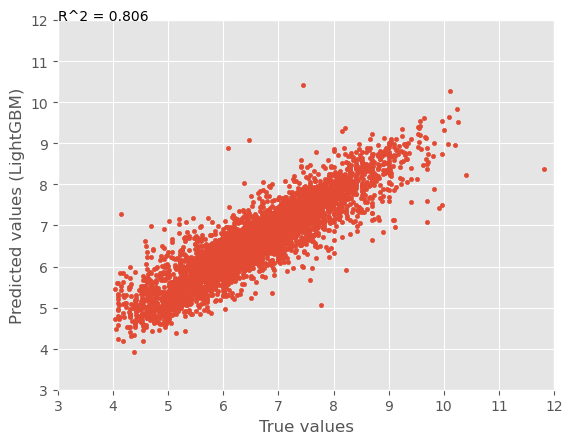

In [175]:
# Scatter plot

limits = 3,12
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (3, 12))
plt.show()

In [176]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.6898 with a standard deviation of 0.0256
SVM optimized model r2_score 0.7126 with a standard deviation of 0.0196


In [177]:
joblib.dump(svm_reg, "OUTPUT/svm_reg.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm.joblib")

['OUTPUT/optimizedCV_svm.joblib']

In [178]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [179]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )

In [180]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/PredResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    rf_5preds.to_excel(writer, sheet_name="RF", )
    lgbm_5preds.to_excel(writer, sheet_name="LGBM", )
    xgb_5preds.to_excel(writer, sheet_name="XGB", )
    knn_5preds.to_excel(writer, sheet_name="KNN", )
    svm_5preds.to_excel(writer, sheet_name="SVM", )